# Capstone Project-Investment and Trading 

Soyoung Park 

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%matplotlib inline 
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import urllib
import math
import datetime as dt
from datetime import datetime
from pandas import datetime
import scipy.optimize as spo
from scipy.spatial import distance
from sklearn.model_selection import TimeSeriesSplit
import datetime
import matplotlib.finance as finance
from IPython.display import display

os.getcwd()

'/Users/parksoy/Desktop/GoogleDrive_Soyoung/Udacity_nanoDegree_MachineLearning/capstone'


# 1. Data preprocessing
## 1-1. Download daily SPY(S&P 500) data, Intel adj close from Yahoo! Finance

In [3]:
#INPUT as global
symbols = ['INTC']
start_date = dt.datetime(1997,1,1)
end_date = dt.datetime(2017,3,9)

#download latest dataset with symbol from Yahoo Finance

def fetch_data(symbol,start_date,end_date):
    """ Downloads .csv files for <symbols> from Yahoo! Finance and saves them in './data' directory."""

    time_frame = "m" # d -> daily, w -> weekly, m -> monthly.
      
    start_date_mm=str(start_date.month-1)
    start_date_yyyy=str(start_date.year)
    start_date_dd=str(start_date.day)
    
    end_date_mm=str(end_date.month-1)
    end_date_yyyy=str(end_date.year)
    end_date_dd=str(end_date.day)

    url="http://real-chart.finance.yahoo.com/table.csv?s="+\
        symbol+\
        "&a="+start_date_mm+"&b="+start_date_dd+"&c="+start_date_yyyy+\
        "&d="+end_date_mm+"&e="+end_date_dd+"&f="+end_date_yyyy+\
        "&g="+time_frame+"+&ignore=.csv"

    csvfile,_=urllib.urlretrieve(url, './data/{}.csv'.format(symbol))
    print "Downloading for "+symbol
    print "URL:"+url
    statinfo = os.stat(csvfile)
    print 'File size:', statinfo.st_size/1000,"KB"

def run():
    #Download csv for symbols
    if "SPY" not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, "SPY")

    for symbol in symbols:
       fetch_data(symbol,start_date,end_date)
    
run()

URL:http://real-chart.finance.yahoo.com/table.csv?s=SPY&a=0&b=1&c=1997&d=2&e=9&f=2017&g=m+&ignore=.csv
File size: 362 KB
URL:http://real-chart.finance.yahoo.com/table.csv?s=INTC&a=0&b=1&c=1997&d=2&e=9&f=2017&g=m+&ignore=.csv
File size: 310 KB


## 1-2 Data preprocessing utils

In [4]:
#utils-the majority of this code is refered from ML4Trading course offered by Udacity. 

def fill_missing_values(df_data):
    """Fill missing values in data frame, in place."""
    df_data.fillna(method="ffill", inplace=True)
    df_data.fillna(method="bfill", inplace=True)
    
def symbol_to_path(symbol, base_dir="data"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(symbol))

def get_data(symbols, dates):
    """Read adjusted close only for given symbols from CSV files."""
    df_final = pd.DataFrame(index=dates)
    if "SPY" not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, "SPY")

    for symbol in symbols:
        file_path = symbol_to_path(symbol)
        df_temp = pd.read_csv(file_path,parse_dates=True,index_col="Date", usecols=["Date", "Adj Close"],na_values=["nan"])
        df_temp = df_temp.rename(columns={"Adj Close": symbol})
        df_final = df_final.join(df_temp)
        if symbol == "SPY":  # drop dates SPY did not trade
            df_final = df_final.dropna(subset=["SPY"])
    return df_final

def normarlize_data(df):
    return df/df.ix[0,:]

def plot_data(df_data,title="Stock Data",xlabel="Date",ylabel="Price"):
    """Plot stock data with appropriate axis labels."""
    ax = df_data.plot(title=title, fontsize=7)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend(loc="best", fontsize=4)
    plt.show()

def plot_selected(df, columns, start_index, end_index):
    """Plot the desired columns over index values in the given range."""
    df_plot=df.ix[end_index:start_index,columns]
    df_plot=normarlize_data(df_plot)
    plot_data(df_plot, title='Selected Stock Prices')

def plot_normalized_data(df, title, xlabel, ylabel):
    #Normalize given stock prices and plot for comparison.
    #This is used to create a chart that illustrates the value of your portfolio over the year and compares it to SPY.
    #Note: Before plotting, portfolio and SPY values should be normalized to 1.0 at the beginning of the period.
    #Also, use the plot_data() utility function to generate and show your plot.
    df=normarlize_data(df)
    plot_data(df, title=title, ylabel="Normalized value")

#indicators

def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    # TODO: Compute upper_band and lower_band
    upper_band=rm+2*rstd
    lower_band=rm-2*rstd
    
    return upper_band, lower_band


#http://matplotlib.org/examples/pylab_examples/finance_work2.html
def moving_average(x, n, type='simple'):
    """compute an n period moving average.type is 'simple' | 'exponential'"""
    x_np = np.asarray(x)
    if type == 'simple': weights = np.ones(n)
    else: weights = np.exp(np.linspace(-1., 0., n))
    weights /= weights.sum()
    a = np.convolve(x_np, weights, mode='full')[:len(x_np)]
    a[:n] = a[n]
    a=pd.Series(a, index=x.index, name=type+" Moving Average")
    return a

def relative_strength(prices, n=14):
    """compute the n period relative strength indicator"""
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1. + rs)
    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        up = (up*(n - 1) + upval)/n
        down = (down*(n - 1) + downval)/n
        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)
        rsi=pd.Series(rsi,index=prices.index,name="RSI")
    return rsi

def moving_average_convergence(x, nslow=26, nfast=12):
    """ compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    emaslow=pd.Series(emaslow, index=x.index, name="emaslow")
    emafast=pd.Series(emafast, index=x.index, name="emafast")
    return emaslow, emafast, emafast - emaslow


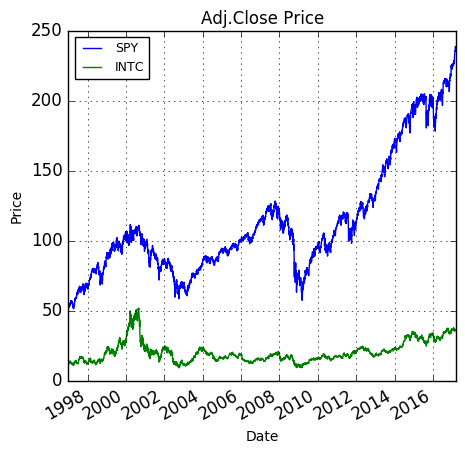

In [5]:
# Read data
plt.rcParams['figure.figsize'] = (5.0, 5.0)
dates = pd.date_range(start_date, end_date)
df_price = get_data(symbols, dates)
title="Adj.Close Price"; xlabel="Date"; ylabel="Price"
ax = df_price.plot(title=title, fontsize=12)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.grid(True)
ax.legend(loc="best", fontsize=9)
plt.show()

In [6]:
display(df_price[:2])
print len(df_price)

,SPY,INTC
1997-01-02,51.586402,11.206980
1997-01-03,52.326773,11.894656


5080


In [7]:
display(df_price[:2])

,SPY,INTC
1997-01-02,51.586402,11.206980
1997-01-03,52.326773,11.894656


## 1-3. Adding more targets/technical indicators based on adj. close price

In [8]:
#Adding more targets

prices = df_price["INTC"]

#Return
df_price["Return_1day"]=prices/prices.shift(1)-1
df_price["Return_7day"]=prices/prices.shift(7)-1
df_price["Return_14day"]=prices/prices.shift(14)-1
df_price["Return_28day"]=prices/prices.shift(28)-1
df_price["Return_120day"]=prices/prices.shift(120)-1
df_price["Return_365day"]=prices/prices.shift(365)-1

df_price["log_Return_1day"]=np.log(df_price["Return_1day"])
df_price["log_Return_7day"]=np.log(df_price["Return_7day"])
df_price["log_Return_14day"]=np.log(df_price["Return_14day"])
df_price["log_Return_28day"]=np.log(df_price["Return_28day"])
df_price["log_Return_120day"]=np.log(df_price["Return_120day"])
df_price["log_Return_365day"]=np.log(df_price["Return_365day"])

df_price.fillna(0,inplace=True)

#technical indicators based on adj. close price

#Bollinger band 
window=20
rm=prices.rolling(window=window).mean()
rstd=prices.rolling(window=window).std()
upper_band, lower_band=get_bollinger_bands(rm, rstd)
 
#RSI
rsi = relative_strength(prices)

#SMA
ma20 = moving_average(prices, 20, type='simple')
ma200 = moving_average(prices, 200, type='simple')
ma50 = moving_average(prices, 50, type='simple')

#MACD
nslow = 26; nfast = 12; nema = 9
emaslow, emafast, macd = moving_average_convergence(prices, nslow=nslow, nfast=nfast)

print "prices",type(prices),"\nrm",type(rm),"\nrstd",type(rstd),"\nupperband",type(upper_band),"\nlowerband",type(lower_band),"\nrsi",type(rsi)
print "\nma20",type(ma20),"\nemaslow",type(emaslow),"\nemafast",type(emafast),"\nmacd",type(macd)
print len(df_price["log_Return_365day"])

prices <class 'pandas.core.series.Series'> 
rm <class 'pandas.core.series.Series'> 
rstd <class 'pandas.core.series.Series'> 
upperband <class 'pandas.core.series.Series'> 
lowerband <class 'pandas.core.series.Series'> 
rsi <class 'pandas.core.series.Series'>

ma20 <class 'pandas.core.series.Series'> 
emaslow <class 'pandas.core.series.Series'> 
emafast <class 'pandas.core.series.Series'> 
macd <class 'pandas.core.series.Series'>
5080


In [9]:
df_features=pd.DataFrame({"SPY_price":df_price["SPY"],
                          "Rolling_mean":rm,
                          "Rolling_std":rstd,
                          "Bollinger_upperband":upper_band,
                          "Bollinger_lowerband":lower_band,
                          "RSI":rsi,
                          "SMA20":ma20,
                          "SMA50":ma50,
                          "SMA200":ma200,
                          "EMA_slow":emaslow,
                          "EMA_fast":emafast,
                          "MACD":macd
                         }, index=prices.index)

fill_missing_values(df_features)
display(df_features[:2])

,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
1997-01-02,11.506095,13.480646,12.261038,12.709446,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,51.586402
1997-01-03,11.506095,13.480646,12.261038,12.709446,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,52.326773


In [10]:
df_merged=df_features.join(df_price, how='inner')
print df_merged.shape,"\n",df_merged.columns.values

(5080, 26) 
['Bollinger_lowerband' 'Bollinger_upperband' 'EMA_fast' 'EMA_slow' 'MACD'
 'RSI' 'Rolling_mean' 'Rolling_std' 'SMA20' 'SMA200' 'SMA50' 'SPY_price'
 'SPY' 'INTC' 'Return_1day' 'Return_7day' 'Return_14day' 'Return_28day'
 'Return_120day' 'Return_365day' 'log_Return_1day' 'log_Return_7day'
 'log_Return_14day' 'log_Return_28day' 'log_Return_120day'
 'log_Return_365day']


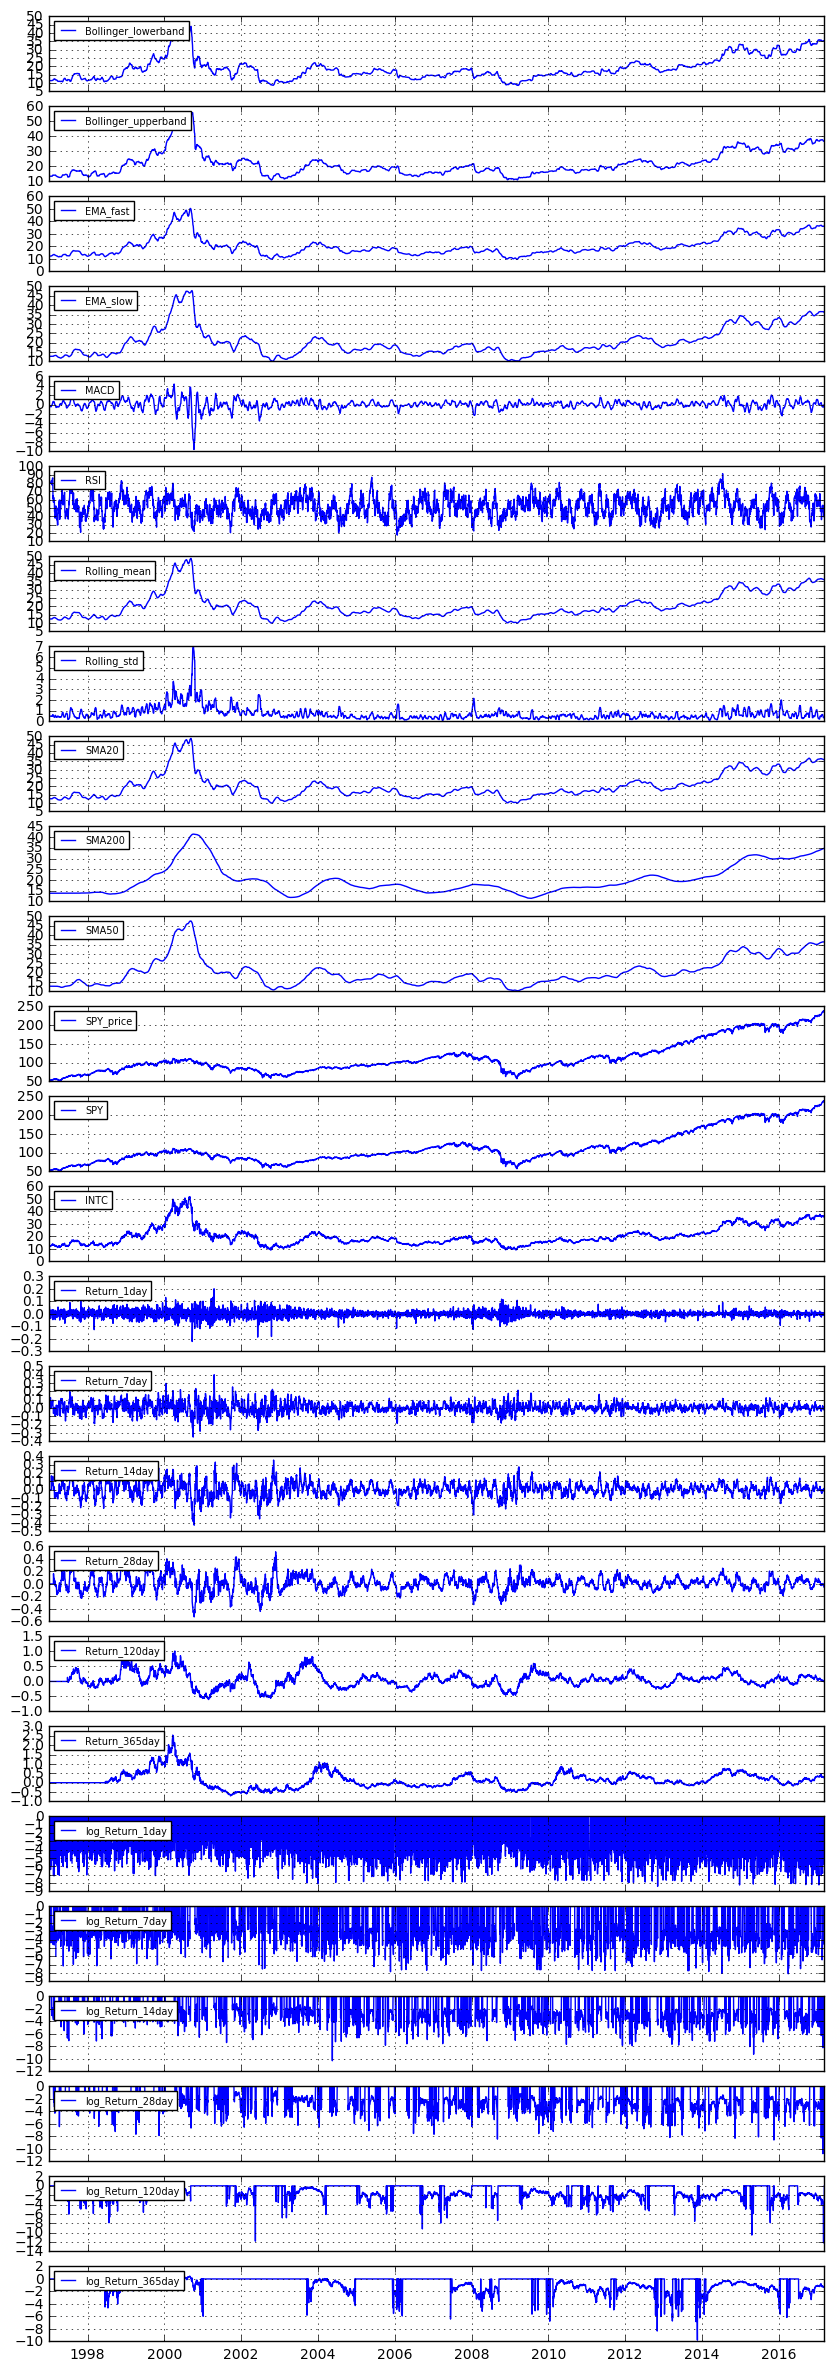

In [11]:
plt.rcParams['figure.figsize'] = (10.0, 30.0)
f, ax = plt.subplots(nrows=len(df_merged.columns),sharex=True) #

for i,colname in enumerate(df_merged.columns):
    ax[i].plot(df_merged[colname])
    ax[i].set_ylabel("")
    ax[i].grid(True)
    ax[i].legend(loc='upper left',fontsize=7)
plt.show()

In [12]:
#Split target(y) and features(X) 

y = df_merged['INTC']
X = pd.DataFrame([  
                    df_merged['Bollinger_lowerband'], 
                    df_merged['Bollinger_upperband'], 
                    df_merged['EMA_fast'],
                    df_merged['EMA_slow'],
                    df_merged['MACD'], 
                    df_merged['RSI'], 
                    df_merged['Rolling_mean'],
                    df_merged['Rolling_std'], 
                    df_merged['SMA20'], 
                    df_merged['SMA200'], 
                    df_merged['SMA50'], 
                    df_merged['SPY_price']
        
                 ]).transpose()


#Scale all features based on z-score 
from scipy.stats import zscore

X_z=X.apply(zscore)
display(X_z[-5:])


,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
2017-03-03,2.349583,1.832786,2.097518,2.138267,-0.188318,-0.648559,2.092198,-0.628428,2.092278,2.196409,2.176807,2.924346
2017-03-06,2.340057,1.829325,2.097048,2.128243,-0.113470,-1.035054,2.085871,-0.612460,2.085951,2.201077,2.173078,2.907715
2017-03-07,2.335867,1.827164,2.091160,2.114977,-0.056019,-0.665658,2.082742,-0.607598,2.082821,2.206180,2.170591,2.891084
2017-03-08,2.328776,1.824308,2.082231,2.105324,-0.050904,-0.878108,2.077881,-0.596658,2.077960,2.210768,2.167751,2.880777
2017-03-09,2.326727,1.819203,2.072969,2.100902,-0.089407,-0.560215,2.074151,-0.607963,2.074230,2.215447,2.165345,2.887804


In [13]:
#split trainset and testset.
print X_z.shape, y.shape
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(X):
    y_train, y_test = y[train_index], y[test_index]
    X_train, X_test = X_z.iloc[train_index], X_z.iloc[test_index]
   

print "X_train, y_train,X_test, y_test",X_train.shape, y_train.shape,X_test.shape, y_test.shape

display(X_train[:1])
display(X_train[-1:])
display(y_train[:1])
display(X_test[:1])
display(X_test[-1:])
display(y_test[:1])

print type(y_train) 

(5080, 12) (5080,)
X_train, y_train,X_test, y_test (3810, 12) (3810,) (1270, 12) (1270,)


,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
1997-01-02,-1.065017,-1.030221,-1.084894,-1.028715,-0.508046,2.418443,-1.056698,-0.389367,-1.039779,-0.932133,-1.025424,-1.446898


,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
2012-02-21,0.45403,0.14494,0.299777,0.246756,0.43425,1.093973,0.290638,-0.828673,0.290591,-0.108645,0.15469,0.223482


1997-01-02    11.20698
Name: INTC, dtype: float64

,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
2012-02-22,0.454247,0.145202,0.300295,0.257381,0.355068,0.361798,0.290882,-0.82842,0.290835,-0.106053,0.159777,0.214184


,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
2017-03-09,2.326727,1.819203,2.072969,2.100902,-0.089407,-0.560215,2.074151,-0.607963,2.07423,2.215447,2.165345,2.887804


2012-02-22    22.647286
Name: INTC, dtype: float64

<class 'pandas.core.series.Series'>


In [14]:
print X_test.index[-1],X_test.index[0]

2017-03-09 00:00:00 2012-02-22 00:00:00


# 2. Fit and predict

## 2.1 Regression of price

In [15]:
#Made a function to train, predict, and plot data vs. prediction

regressor_RMSE={}

def train_predict_evaluate(regressor,X_train, y_train,X_test):
    regressor.fit(X_train, y_train)
    y_train_pred=regressor.predict(X_train)
    y_test_pred=regressor.predict(X_test)
   
    #Evaluation of regression
    print "\n****Evaluation of regression in testset****"
    Rsqr=regressor.score(X_test,y_test)
    RMSE=np.sqrt((np.sum((y_test_pred-y_test)**2))/len(y_test_pred))

    #R square=(1 - u/v), where u is the regression sum of squares ((y_true - y_pred) ** 2).sum() 
    #and v is the residual sum of squares ((y_true - y_true.mean()) ** 2).sum()
    #R^2=coefficient of determination of the prediction in test set
    print "R^2 ==",Rsqr
    print "RMSE==",RMSE
    regressor_RMSE.update({regressor.__class__.__name__: RMSE})


    ##convert np array to df to plot together 
    df_train_pred = pd.DataFrame({'y_train_pred':y_train_pred}, index=y_train.index)
    df_train_pred.head(2)

    df_merged_trainPred=y_train.to_frame('INTC_price').join(df_train_pred)
    df_merged_trainPred.head(2)

    #Plot 
    plt.rcParams['figure.figsize'] = (20.0, 5.0)
    ax1=df_merged_trainPred.plot()
    ax1.set_xlabel('date',fontsize=12)
    ax1.set_ylabel("adj.close price",fontsize=12)
    ax1.set_title('Trainset model vs. data')
    ax1.grid(True)
    ax1.legend(loc="best", fontsize=14)

    #Check testset data vs. prediction
    df_test_pred = pd.DataFrame({'y_test_pred':y_test_pred}, index=y_test.index)
    df_test_pred.head(2)
    df_merged_testPred=y_test.to_frame('INTC_price').join(df_test_pred)
    df_merged_testPred.head(2)

    ax2=df_merged_testPred.plot()
    ax2.set_xlabel('date',fontsize=12)
    ax2.set_ylabel("adj.close price",fontsize=12)
    ax2.set_title('Testset model vs. data')
    ax2.grid(True)
    ax2.legend(loc="best", fontsize=14)

### 2.1.1 Base model: knn regressor


****Evaluation of regression in testset****
R^2 == 0.763254820219
RMSE== 2.81872067447


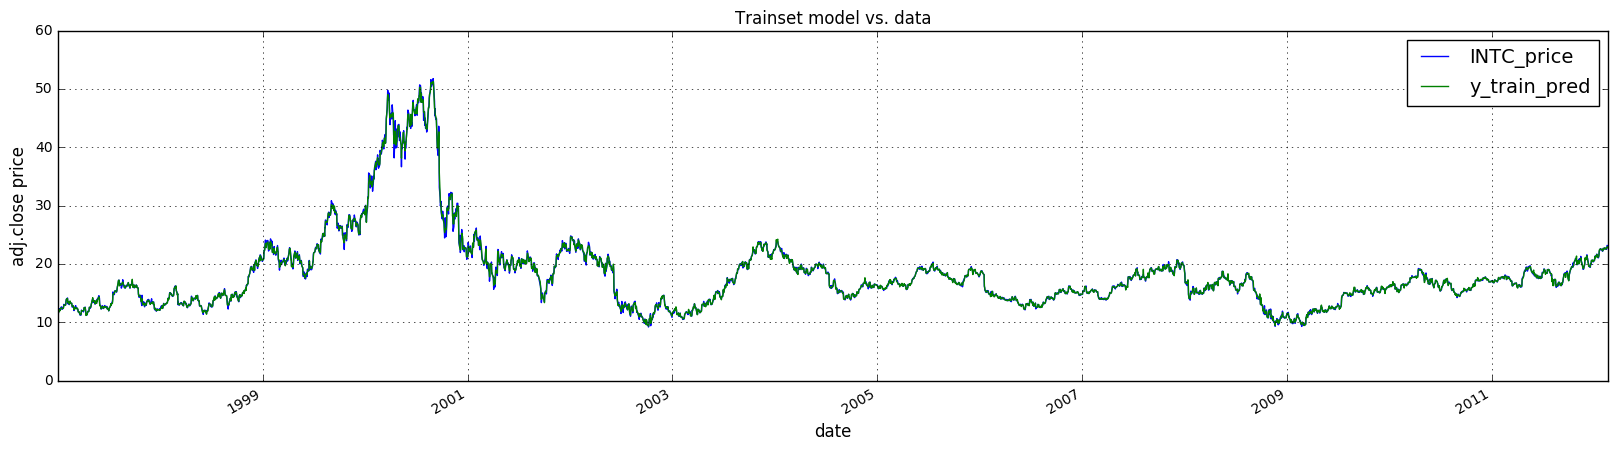

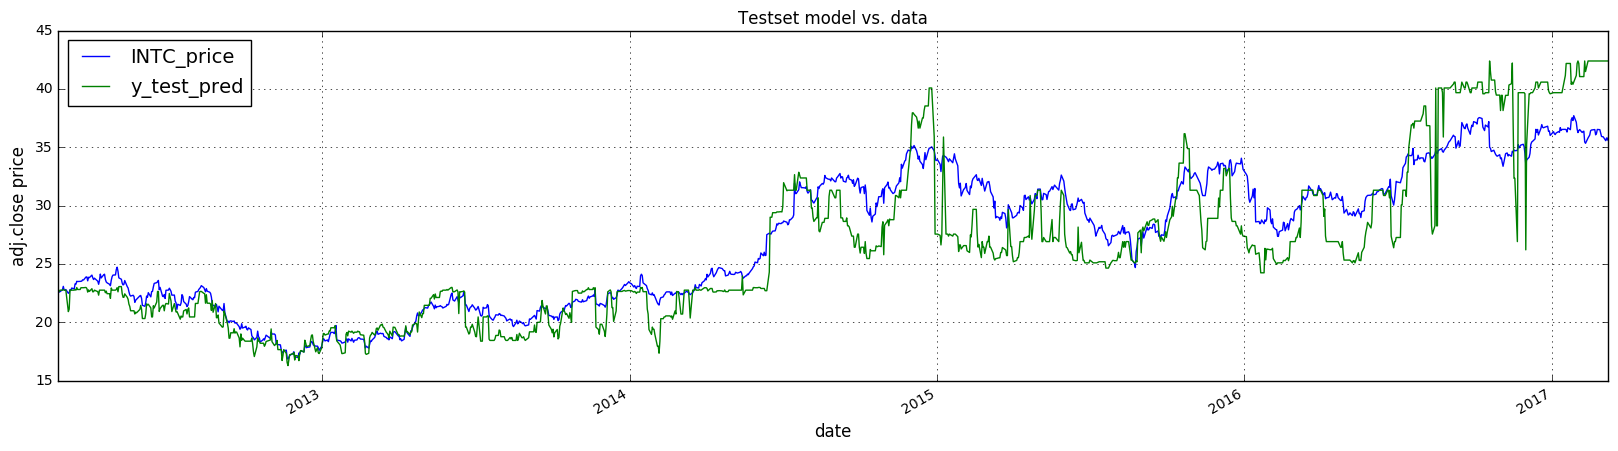

In [16]:
#Baseline model, knn regressor

from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=3)

train_predict_evaluate(regressor,X_train, y_train, X_test)

##### baseline knn shows poor performance. 


### 2.1.2. RandomForest regressor


****Evaluation of regression in testset****
R^2 == 0.513160847839
RMSE== 4.04207359858


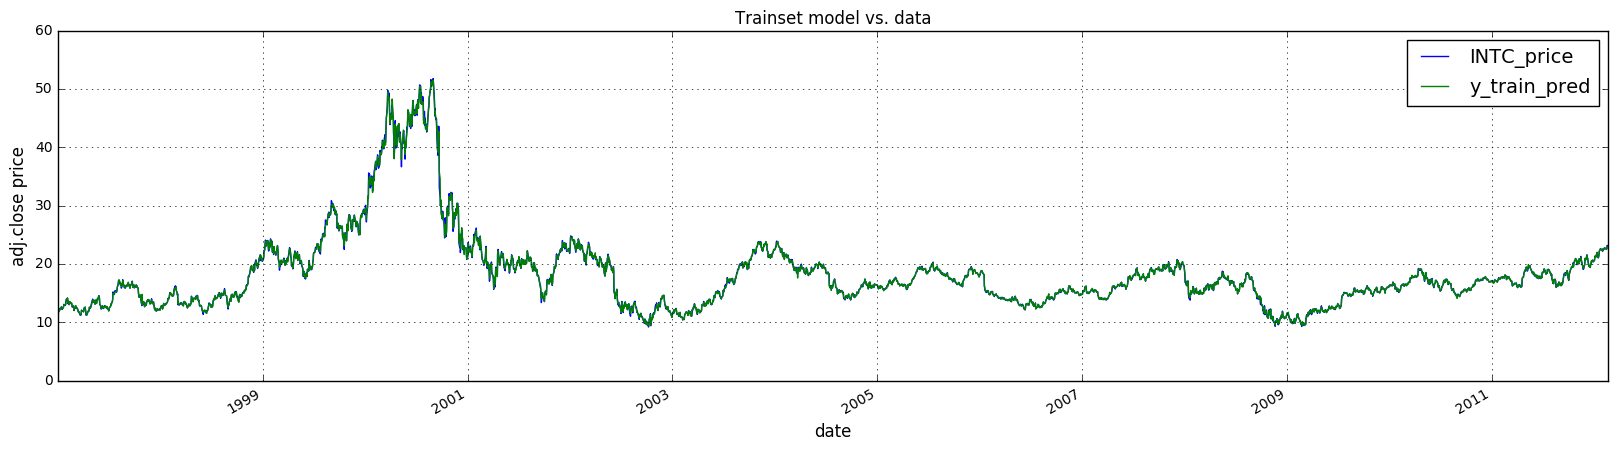

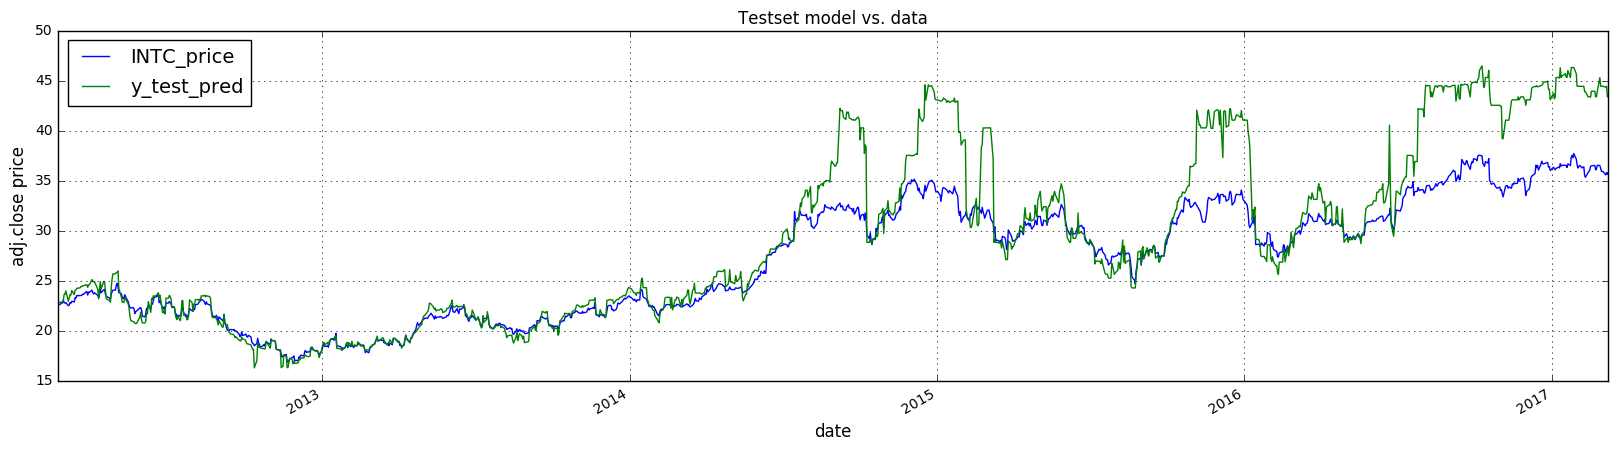

In [17]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()
train_predict_evaluate(regressor,X_train, y_train,X_test)

In [18]:
#For randomforest regressor; feature importance in rank 

feat_imprt=regressor.feature_importances_
features=np.array(X_train.columns)
featTable=np.vstack((features,feat_imprt))
featTable
ft=pd.DataFrame(featTable.T,columns=['features','values'])
ft.sort_values(by='values',ascending=False)

,features,values
2,EMA_fast,0.704847
0,Bollinger_lowerband,0.133038
8,SMA20,0.129628
5,RSI,0.0145138
11,SPY_price,0.00878942
1,Bollinger_upperband,0.00424703
10,SMA50,0.000977754
9,SMA200,0.000937268
7,Rolling_std,0.000936054
6,Rolling_mean,0.000766244


### 2.1.3. Adaboost regressor with Decision tree

#### 2.1.3.1 Decision tree first 


****Evaluation of regression in testset****
R^2 == 0.623174825713
RMSE== 3.55616106371


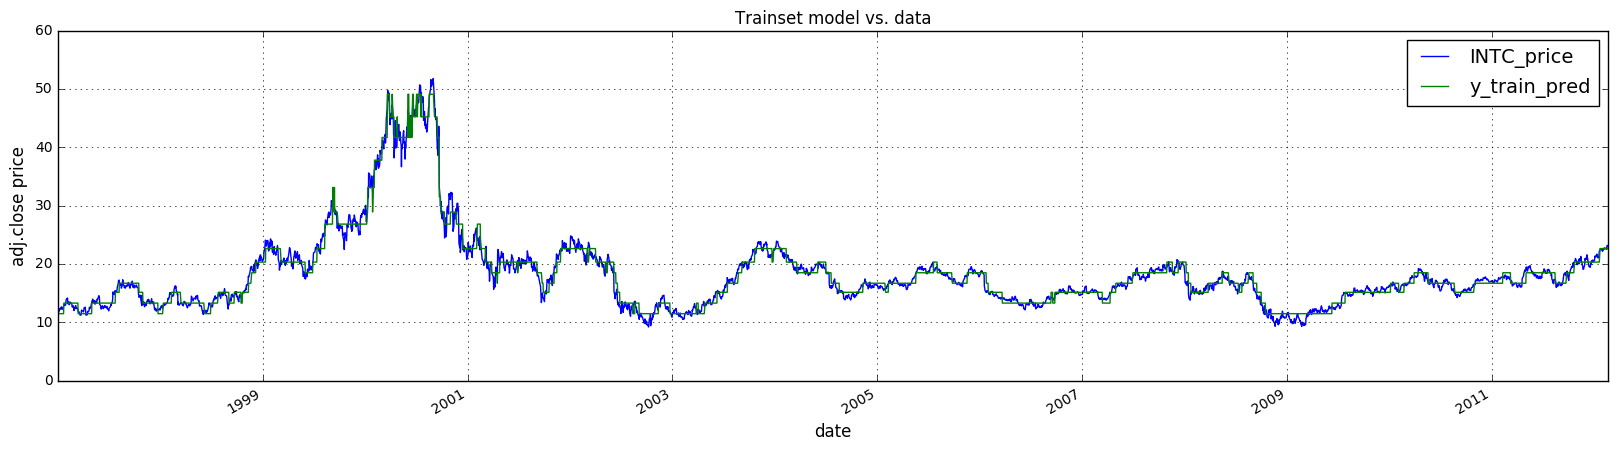

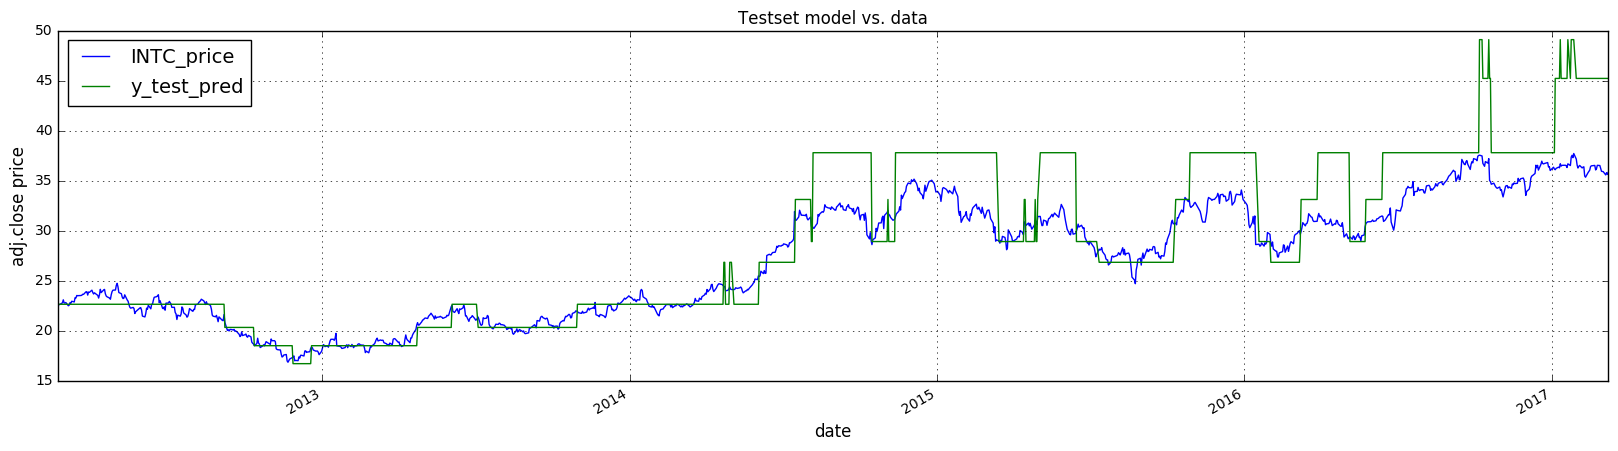

In [19]:
from sklearn.tree import DecisionTreeRegressor

rng = np.random.RandomState(1)
regressor= DecisionTreeRegressor(max_depth=4)

#Decision tree first
train_predict_evaluate(regressor,X_train, y_train,X_test)

#### 2.1.3.2 AdaBoost


****Evaluation of regression in testset****
R^2 == 0.818693828045
RMSE== 2.46670811432


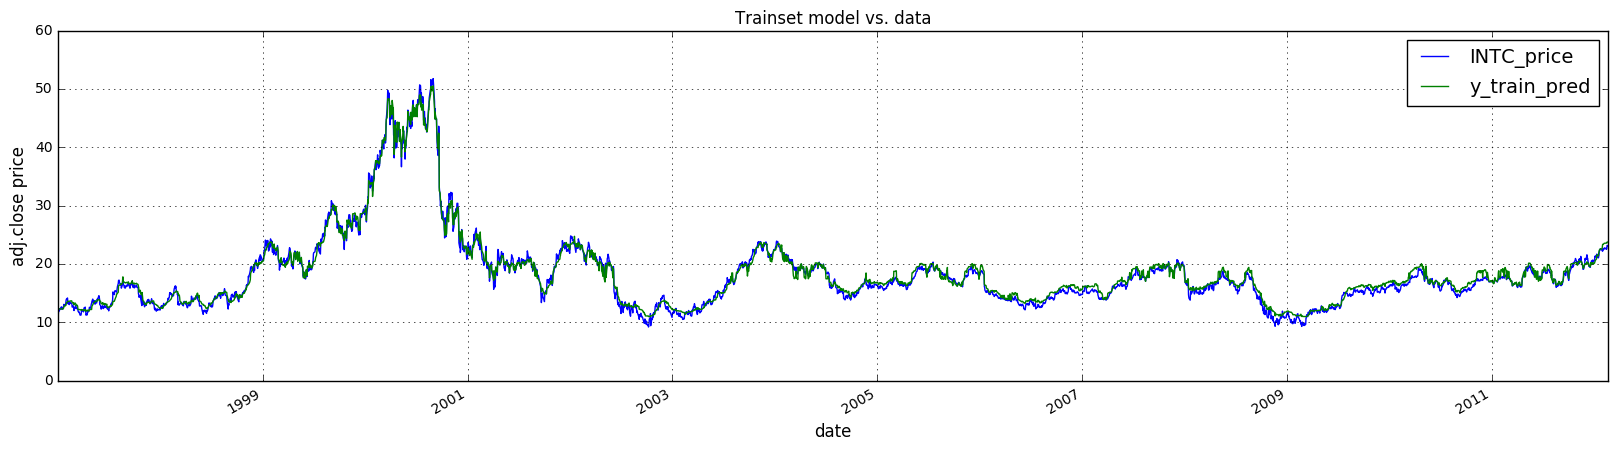

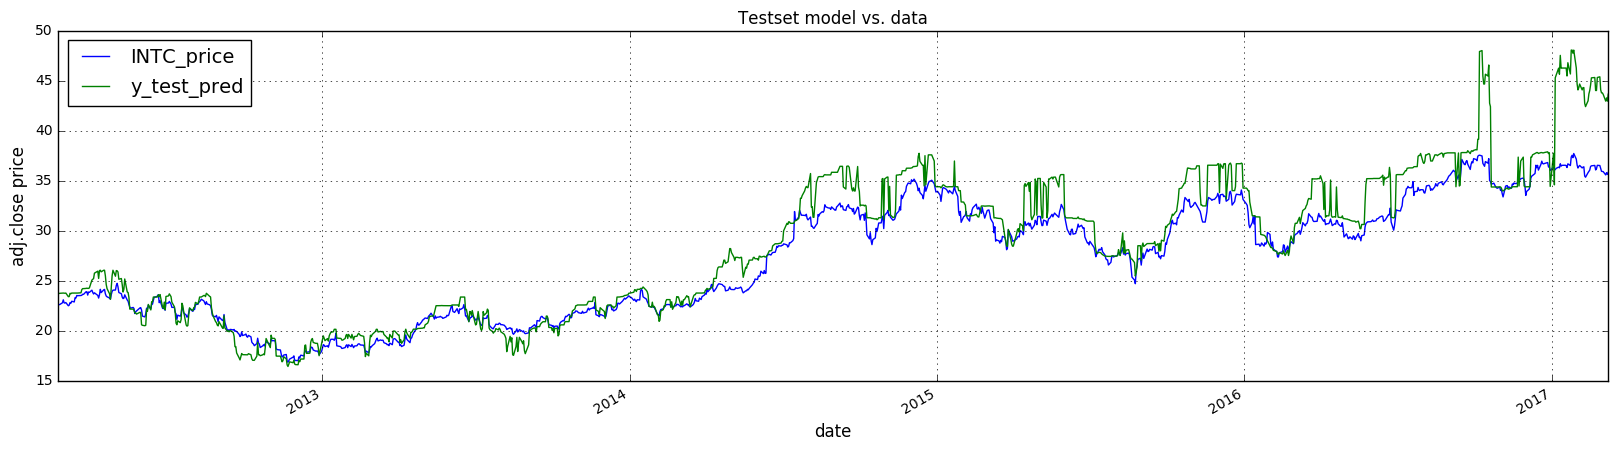

In [20]:
from sklearn.ensemble import AdaBoostRegressor

regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

train_predict_evaluate(regressor,X_train, y_train,X_test)

### 2.1.4 SVR regressor


****Evaluation of regression in testset****
R^2 == 0.877146583673
RMSE== 2.03050978731


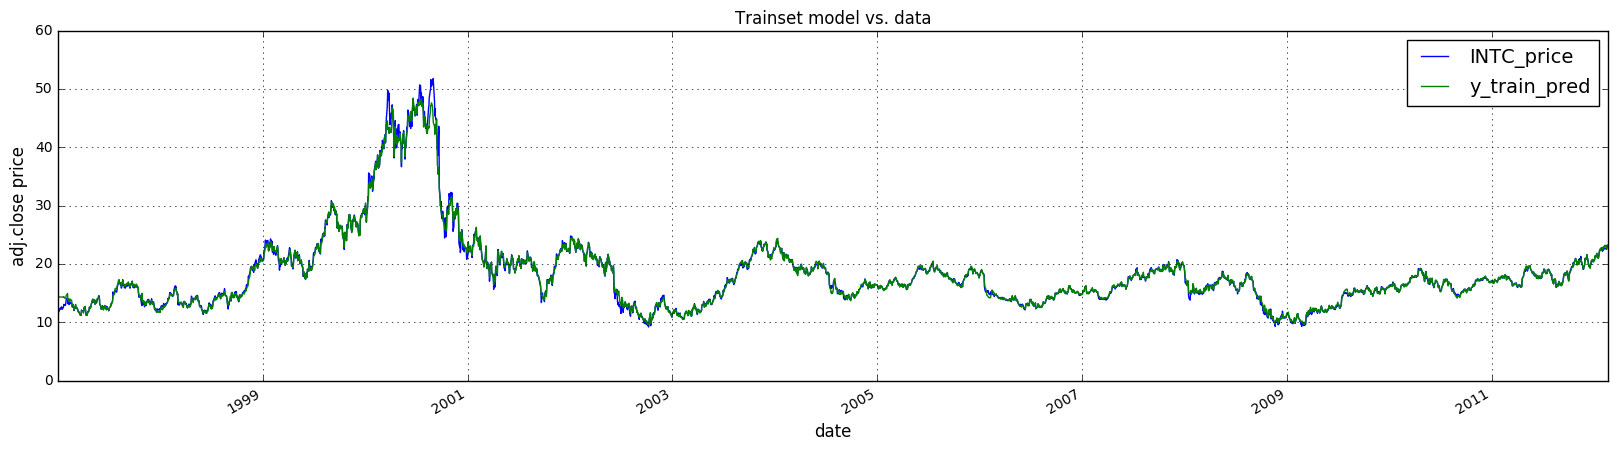

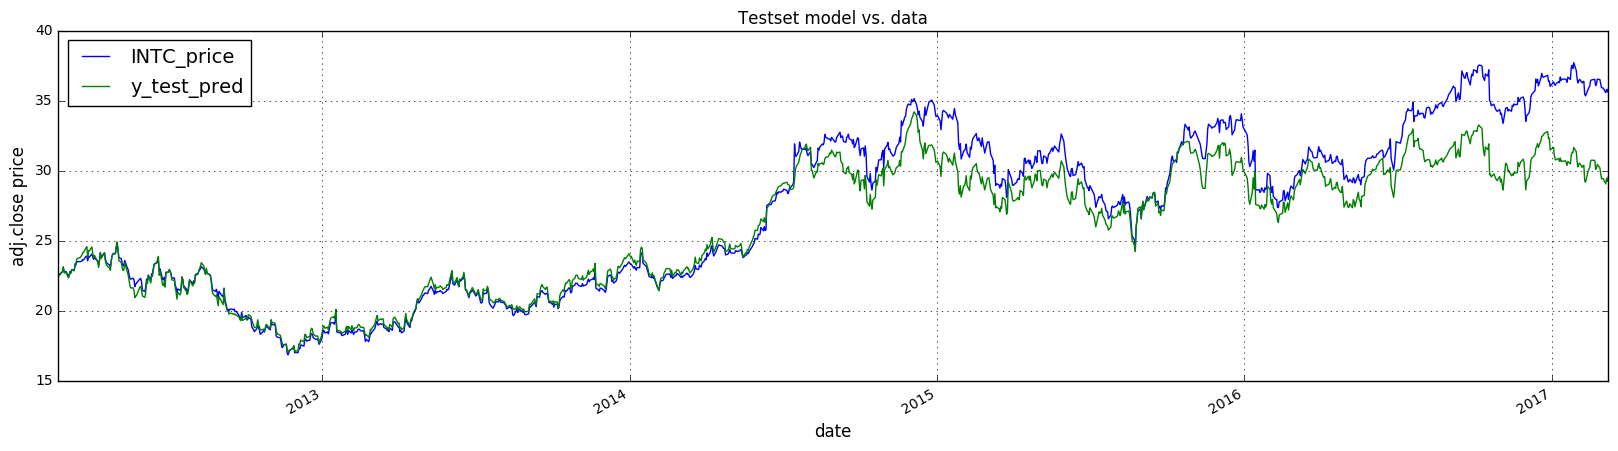

In [21]:
from sklearn.svm import SVR

np.random.seed(0)
regressor= SVR()#C=1.0, epsilon=0.2

train_predict_evaluate(regressor,X_train, y_train,X_test)

### Summary of price regression 

,regressor,RMSE
2,SVR,2.030510
3,AdaBoostRegressor,2.466708
1,KNeighborsRegressor,2.818721
0,DecisionTreeRegressor,3.556161
4,RandomForestRegressor,4.042074


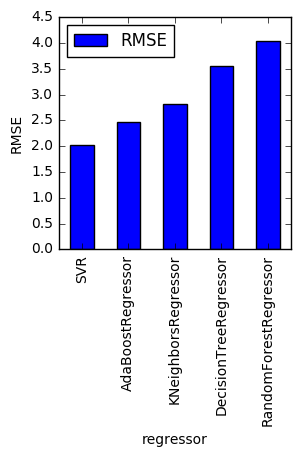

In [22]:
#summary of RMSE for all regressors
plt.rcParams['figure.figsize'] = (3.0, 3.0)
regressor_RMSE_df=pd.DataFrame(list(regressor_RMSE.iteritems()), columns=['regressor','RMSE'])

regressor_RMSE_df=regressor_RMSE_df.sort_values(by=['RMSE'],ascending=True)
display(regressor_RMSE_df)

ax=regressor_RMSE_df.plot(x=regressor_RMSE_df['regressor'],kind='bar')
ax.set_ylabel('RMSE')

For price regression, SVR gives the best performance. 

### 2.2 Regression of return

In [23]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from pandas.tools.plotting import autocorrelation_plot

#### 2.2.1 Forcasting the return with ARIMA model-Testing stationary, checking lag

In [24]:
#load the data

df_price = get_data(symbols, dates)

prices = df_price["INTC"]

#Return
df_price["Return_14day"]=prices/prices.shift(14)-1
df_price["log_Return_14day"]=np.log(df_price["Return_14day"])
'''
df_price["Return_1day"]=prices/prices.shift(1)-1
df_price["Return_7day"]=prices/prices.shift(7)-1

df_price["Return_28day"]=prices/prices.shift(28)-1
df_price["Return_120day"]=prices/prices.shift(120)-1
df_price["Return_365day"]=prices/prices.shift(365)-1

df_price["log_Return_1day"]=np.log(df_price["Return_1day"])
df_price["log_Return_7day"]=np.log(df_price["Return_7day"])

df_price["log_Return_28day"]=np.log(df_price["Return_28day"])
df_price["log_Return_120day"]=np.log(df_price["Return_120day"])
df_price["log_Return_365day"]=np.log(df_price["Return_365day"])
'''

#REMOVE NaN instead of filling with zero if want to incorporate log return. 
#df_price.fillna(0,inplace=True)
#index_NAN= df_merged["log_Return_14day"].index[df_merged["log_Return_14day"].apply(np.isinf)]
print df_price.shape
display(df_price[:16])
df_price=df_price.dropna(how="any",subset=["Return_14day","log_Return_14day"])
display(df_price[:16])

df_merged=df_features.join(df_price, how='inner')
print df_merged.shape,"\n",df_merged.columns.values

(5080, 4)


,SPY,INTC,Return_14day,log_Return_14day
1997-01-02,51.586402,11.206980,NaN,NaN
1997-01-03,52.326773,11.894656,NaN,NaN
1997-01-06,51.869523,11.937636,NaN,NaN
1997-01-07,52.500978,12.324454,NaN,NaN
1997-01-08,52.043727,12.227750,NaN,NaN
1997-01-09,52.479240,12.292219,NaN,NaN
1997-01-10,53.045406,12.421159,NaN,NaN
1997-01-13,52.969175,12.625313,NaN,NaN
1997-01-14,53.633310,12.646803,NaN,NaN
1997-01-15,53.502657,12.206260,NaN,NaN


,SPY,INTC,Return_14day,log_Return_14day
1997-01-22,54.939847,13.076601,0.166826,-1.790801
1997-01-23,54.177738,13.044366,0.096658,-2.336579
1997-01-24,53.480918,12.936916,0.083708,-2.480416
1997-01-27,53.328452,12.904681,0.047079,-3.055921
1997-01-28,53.480918,12.979896,0.061511,-2.788533
1997-01-29,54.003533,13.306651,0.082526,-2.494638
1997-01-30,54.700353,13.768837,0.108499,-2.221018
1997-01-31,54.634989,13.951561,0.105047,-2.253350
1997-02-03,54.798327,14.091292,0.114218,-2.169649
1997-02-04,55.135865,14.166532,0.160596,-1.828866


(2740, 16) 
['Bollinger_lowerband' 'Bollinger_upperband' 'EMA_fast' 'EMA_slow' 'MACD'
 'RSI' 'Rolling_mean' 'Rolling_std' 'SMA20' 'SMA200' 'SMA50' 'SPY_price'
 'SPY' 'INTC' 'Return_14day' 'log_Return_14day']


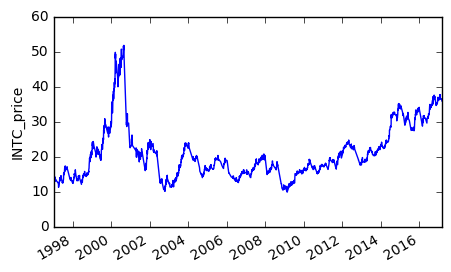

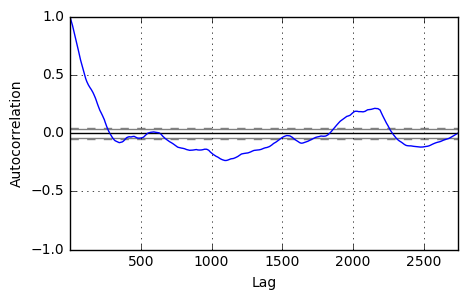

ADF Statistic: -2.290183
p-value: 0.175154
Critical Values:
	5%: -2.863
	1%: -3.433
	10%: -2.567


In [25]:
series=df_merged['INTC']

plt.rcParams['figure.figsize'] = (5.0, 3.0)

# line plot
ax=series.plot()
ax.set_ylabel('INTC_price')
plt.show()

# autocorrelation plot
autocorrelation_plot(series)
plt.show()

# statistical test #The null hypothesis of the test is that the time series is non-stationary.
result = adfuller(series) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

Test statistic value was -2.290183. This is larger than all of the critical values at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series appears to be **"non-stationary"** with a low likelihood of the result being a statistical fluke.

#### 2.2.2 Make indicator as stationary by taking return

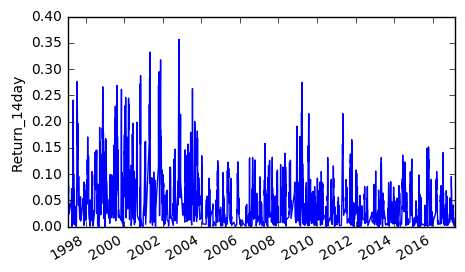

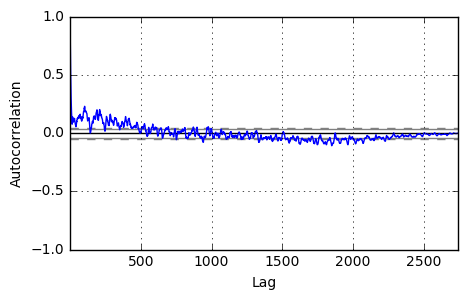

ADF Statistic: -7.783218
p-value: 0.000000
Critical Values:
	5%: -2.863
	1%: -3.433
	10%: -2.567


In [26]:
series=df_price["Return_14day"]

plt.rcParams['figure.figsize'] = (5.0, 3.0)

# line plot
ax=series.plot()
ax.set_ylabel('Return_14day')
plt.show()

# autocorrelation plot
autocorrelation_plot(series)
plt.show()

# statistical test #The null hypothesis of the test is that the time series is non-stationary.
result = adfuller(series) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

** 14-day return is now stationary. **

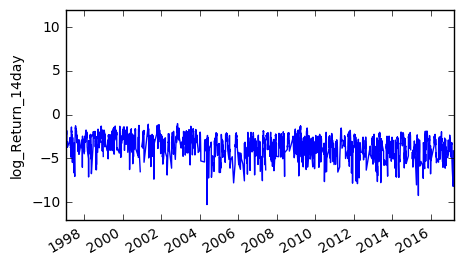

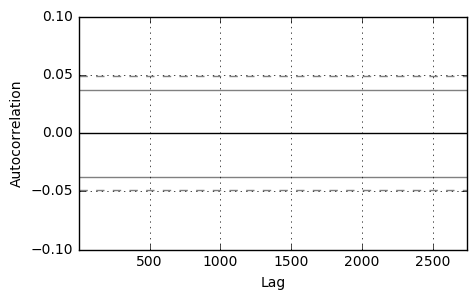

"\n# statistical test #The null hypothesis of the test is that the time series is non-stationary.\nresult = adfuller(series) \nprint('ADF Statistic: %f' % result[0])\nprint('p-value: %f' % result[1])\nprint('Critical Values:')\nfor key, value in result[4].items():\n    print('\t%s: %.3f' % (key, value))\n"

In [27]:
series=df_price["log_Return_14day"]

plt.rcParams['figure.figsize'] = (5.0, 3.0)

# line plot
ax=series.plot()
ax.set_ylabel('log_Return_14day')
ax.set_ylim(-12,12)
plt.show()

# autocorrelation plot
ax2=autocorrelation_plot(series)
ax2.set_ylim(-0.1,0.1)
plt.show()

'''
# statistical test #The null hypothesis of the test is that the time series is non-stationary.
result = adfuller(series) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
'''

#### 2.2.3. residual after a simple model

In [28]:
#Forcasting the return with ARIMA model

#DROP any inf - fillingNA with zero causes large error in price backcalculation. Need to remove inf.
index_INF= df_merged["log_Return_14day"].index[df_merged["log_Return_14day"].apply(np.isinf)]
print index_INF.strftime("%Y-%m-%d")


['1997-04-11' '1998-09-11' '1998-12-30' '1999-12-16' '2000-10-24'
 '2000-12-22' '2005-04-07' '2006-07-28' '2007-06-13' '2010-11-30'
 '2012-03-01' '2014-12-23' '2015-09-29']


In [29]:
display(df_merged['1997-04-10':'1997-04-12'])#'2012-02-22':'2012-03-01'
df_merged=df_merged.drop(index_INF)
display(df_merged['1997-04-10':'1997-04-12'])

,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price,SPY,INTC,Return_14day,log_Return_14day
1997-04-10,11.097994,12.680254,12.019636,12.052892,-0.033256,44.217008,11.889124,0.395565,11.889124,13.830099,12.557964,53.008059,53.008059,11.801860,0.030019,-3.505933
1997-04-11,11.008116,12.677695,12.061712,11.983698,0.078014,36.578023,11.842906,0.417395,11.842906,13.830099,12.516259,51.324953,51.324953,11.221441,0.000000,-inf


,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price,SPY,INTC,Return_14day,log_Return_14day
1997-04-10,11.097994,12.680254,12.019636,12.052892,-0.033256,44.217008,11.889124,0.395565,11.889124,13.830099,12.557964,53.008059,53.008059,11.80186,0.030019,-3.505933


In [30]:
#Forcasting the return with ARIMA model

y = df_merged["log_Return_14day"]

tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(y):
    y_train, y_test = y[:len(train_index)], y[len(train_index):(len(train_index)+len(test_index))]

print "y_train, y_test",y_train.shape,y_test.shape

#size = int(len(X) * 0.66)
#train, test = X[0:size], X[size:len(X)]

history = [y for y in y_train]
predictions = []

for t in range(len(y_test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    observ = y_test[t]
    history.append(observ)

# evaluate forecasts
RMSE = sqrt(mean_squared_error(y_test, predictions))
print "RMSE==",RMSE

#Rsqr=model_fit.score(predictions,history)
#print "R^2 ==",Rsqr

y_train, y_test (2046,) (681,)
RMSE== 0.85663436811


In [31]:
#Log to dictionary to compare with other models
all_regressor_RMSE={}
all_regressor_RMSE.update({"ARIMA": RMSE})
print all_regressor_RMSE

{'ARIMA': 0.8566343681103521}


,pred_y,test_y
2012-04-16,-4.590198,-4.853097
2012-04-17,-4.865438,-4.611938


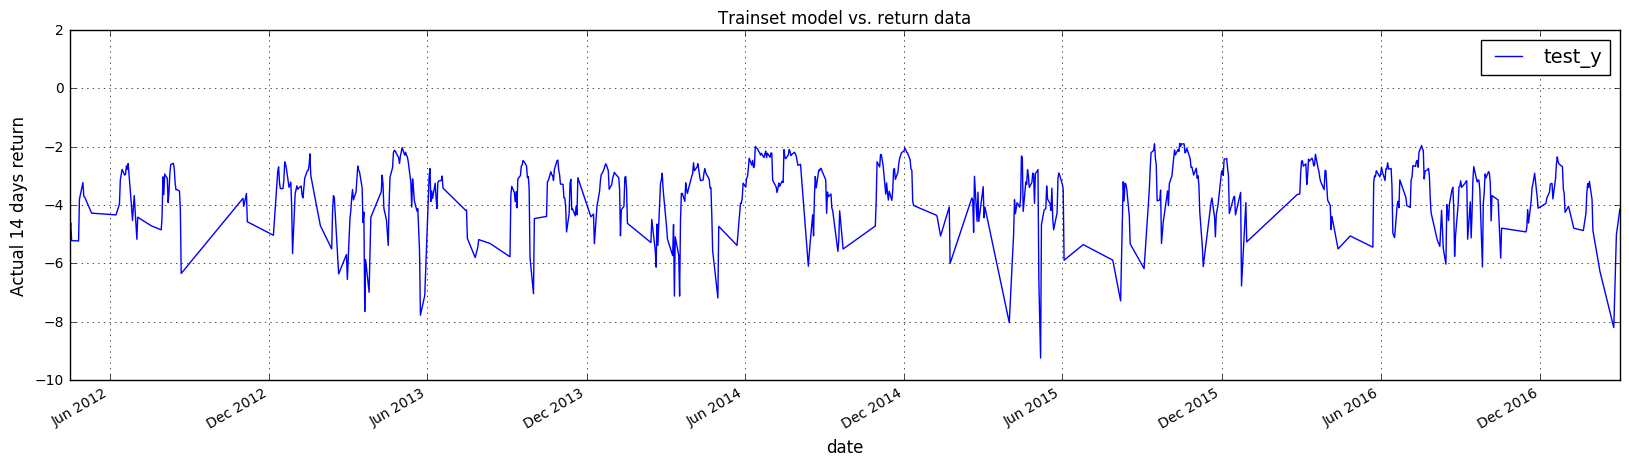

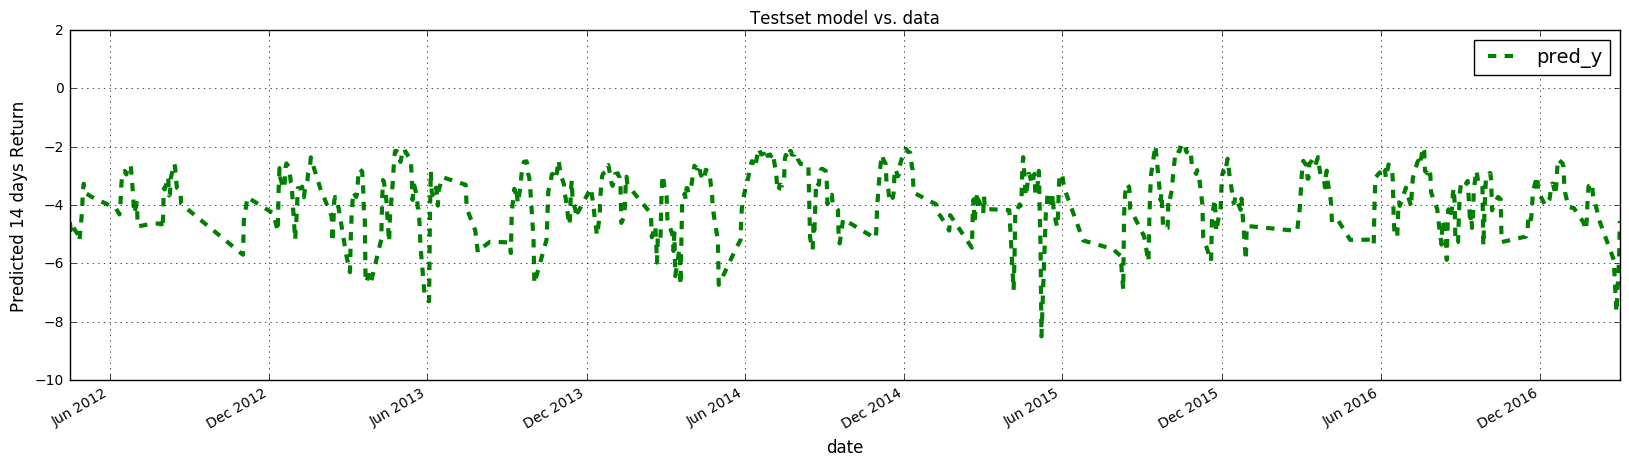

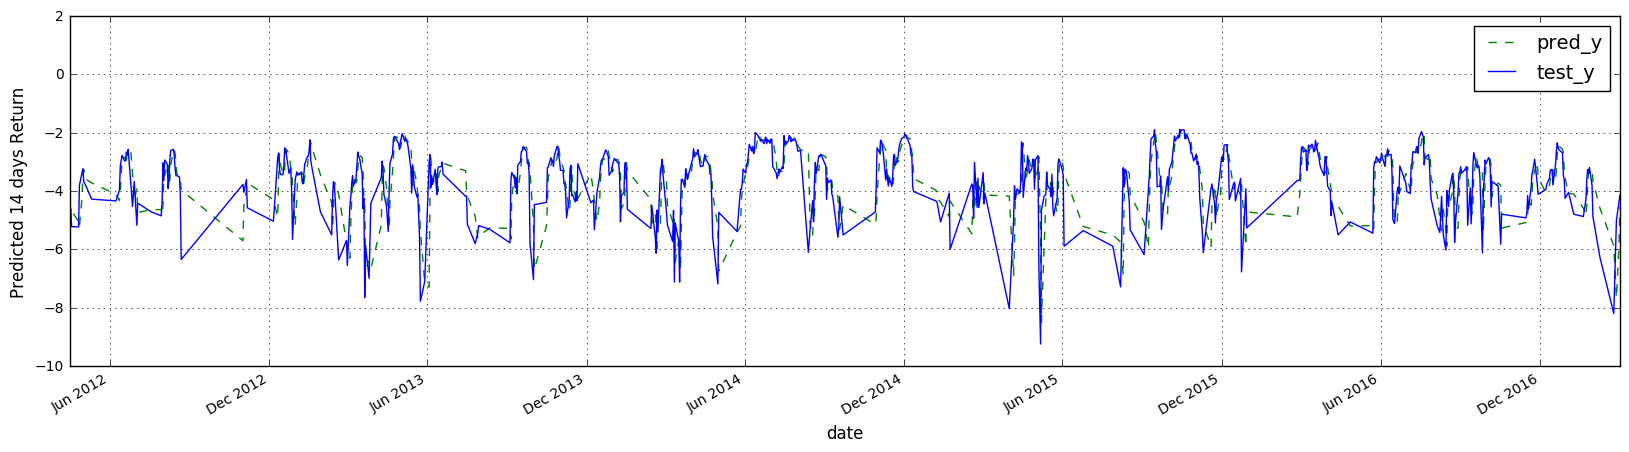

In [32]:
#Deal with dataframe and plot pred vs. test data
plt.rcParams['figure.figsize'] = (20.0, 5.0)

test_y = pd.DataFrame({'test_y':y_test}, index=y_test.index)
prediction_y=pd.Series( (v[0] for v in predictions))
prediction_y_df=pd.DataFrame({'pred_y':[v[0] for v in predictions]},  index=y_test.index)
test_pred_y=prediction_y_df.join(test_y)
display(test_pred_y[:2])

#Plot return data vs. prediction

ax1=test_pred_y['test_y'].plot()
ax1.set_xlabel('date',fontsize=12)
ax1.set_ylabel("Actual 14 days return",fontsize=12)
ax1.set_ylim([-10,2])
ax1.set_title('Trainset model vs. return data')
ax1.grid(True)
ax1.legend(loc="best", fontsize=14)
plt.show()

#Check testset data vs. prediction
ax2=test_pred_y['pred_y'].plot(style=['g--'],lw=3) #color='green',
ax2.set_xlabel('date',fontsize=12)
ax2.set_ylabel("Predicted 14 days Return",fontsize=12)
ax2.set_ylim([-10,2])
ax2.set_title('Testset model vs. data')
ax2.grid(True)
ax2.legend(loc="best", fontsize=14)
plt.show()

#Check testset data vs. prediction
ax3=test_pred_y.plot(style=['g--','b'])
ax3.set_xlabel('date',fontsize=12)
ax3.set_ylabel("Predicted 14 days Return",fontsize=12)
ax3.set_ylim([-10,2])
ax2.set_title('Testset model vs. data')
ax3.grid(True)
ax3.legend(loc="best", fontsize=14)
plt.show()

,pred_today_price,calc_today_price,INTC,Error_pred_actual
2017-02-08,36.683127,36.380001,36.380001,0.833220
2017-02-24,36.621900,36.529999,36.529999,0.251578
2017-02-27,36.286847,36.509998,36.509998,-0.611204
2017-03-02,35.557234,35.910000,35.910000,-0.982360
2017-03-03,35.714752,35.900002,35.900002,-0.516016


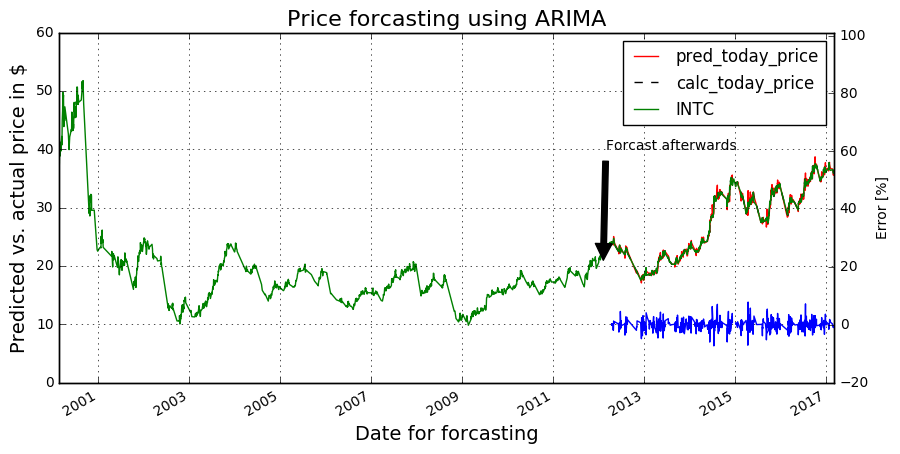

In [33]:
#convert to price to compute accuracy of actual price prediction for this ARIMA model

#actual price
df_price["calc_return_14days"]=np.exp(test_pred_y['test_y'])
df_price["calc_today_price"]=(df_price["calc_return_14days"]+1)*prices.shift(14)
df_price['Error_pred_actual']=(df_price["calc_today_price"]-df_price["INTC"])/df_price["INTC"]*100

#predicted price
df_price["pred_return_14days"]=np.exp(test_pred_y['pred_y'])
df_price["pred_today_price"]=(df_price["pred_return_14days"]+1)*prices.shift(14)
df_price['Error_pred_actual']=(df_price["pred_today_price"]-df_price["INTC"])/df_price["INTC"]*100


#check if done correctly
display(df_price[["pred_today_price","calc_today_price","INTC","Error_pred_actual"]].loc['2012-02-22':][-5:]) #'2012-02-28'
fig=plt.figure()

plt.rcParams['figure.figsize'] = (10.0, 5.0)

ax1=df_price[["pred_today_price","calc_today_price","INTC","Error_pred_actual"]].plot(style=['r-','k--','g','b'],
                                                                  secondary_y=['Error_pred_actual']) #  lw=3, legend=['a','b'],
ax1.set_xlim('2000-02-22','2017-03-09')
ax1.set_xlabel('Date for forcasting',fontsize=14)
ax1.set_ylabel('Predicted vs. actual price in $',fontsize=14)
ax1.right_ax.set_ylabel('Error [%]')
ax1.right_ax.set_ylim(-20,101)
ax1.annotate('Forcast afterwards', xy=('2012-02-08', 20), xytext=('2012-02-29', 40),
            arrowprops=dict(facecolor='black', shrink=0.05), 
            ) #
ax1.grid('on')
ax1.set_title("Price forcasting using ARIMA",fontsize=16)
ax1.legend(loc='best')

#### 2.2.4 Summary of regression on price, return for all regressors used previously

In [34]:
#Retrive data again

df_price = get_data(symbols, dates)

prices = df_price["INTC"]

#Return
df_price["Return_7day"]=prices/prices.shift(7)-1
df_price["Return_14day"]=prices/prices.shift(14)-1
df_price["Return_28day"]=prices/prices.shift(28)-1

df_price["log_Return_7day"]=np.log(df_price["Return_7day"])
df_price["log_Return_14day"]=np.log(df_price["Return_14day"])
df_price["log_Return_28day"]=np.log(df_price["Return_28day"])

#REMOVE NaN instead of filling with zero if want to incorporate log return. 
#REMOVE any inf
print df_price.shape
display(df_price[:16])
df_price=df_price.dropna(how="any",subset=["Return_7day","log_Return_7day","Return_14day","log_Return_14day","Return_28day","log_Return_28day"])
print df_price.shape
display(df_price[:16])


(5080, 8)


,SPY,INTC,Return_7day,Return_14day,Return_28day,log_Return_7day,log_Return_14day,log_Return_28day
1997-01-02,51.586402,11.206980,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-03,52.326773,11.894656,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-06,51.869523,11.937636,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-07,52.500978,12.324454,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-08,52.043727,12.227750,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-09,52.479240,12.292219,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-10,53.045406,12.421159,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-13,52.969175,12.625313,0.126558,NaN,NaN,-2.067055,NaN,NaN
1997-01-14,53.633310,12.646803,0.063234,NaN,NaN,-2.760913,NaN,NaN
1997-01-15,53.502657,12.206260,0.022502,NaN,NaN,-3.794139,NaN,NaN


(1719, 8)


,SPY,INTC,Return_7day,Return_14day,Return_28day,log_Return_7day,log_Return_14day,log_Return_28day
1997-02-18,57.052120,13.295903,0.009796,0.024346,0.087355,-4.625782,-3.715393,-2.437777
1997-04-08,53.642008,12.606648,0.053795,0.072097,0.001601,-2.922566,-2.629739,-6.437325
1997-04-09,53.204827,12.231800,0.022462,0.066542,0.018003,-3.795941,-2.709926,-4.017192
1997-04-23,54.428932,12.575753,0.093458,0.040000,0.035398,-2.370243,-3.218875,-3.341092
1997-04-24,54.155641,12.565004,0.115458,0.007759,0.059837,-2.158849,-4.858957,-2.816135
1997-04-29,55.762294,12.902614,0.094266,0.054842,0.125033,-2.361634,-2.903302,-2.079179
1997-04-30,56.024602,13.171419,0.106972,0.116046,0.149548,-2.235184,-2.153768,-1.900136
1997-05-01,55.959063,13.225180,0.091766,0.178563,0.178563,-2.388514,-1.722811,-1.722811
1997-05-02,56.964577,13.558497,0.078146,0.178907,0.207111,-2.549177,-1.720888,-1.574501
1997-05-05,58.319836,13.977832,0.112442,0.240882,0.219929,-2.185322,-1.423449,-1.514451


In [35]:
# drop any NaN that previous dropna didn't take care of-(why??)
index_INF= df_price.index[df_price["log_Return_28day"].apply(np.isinf)]
print index_INF.strftime("%Y-%m-%d")
df_price=df_price.drop(index_INF)
index_INF= df_price.index[df_price["log_Return_14day"].apply(np.isinf)]
print index_INF.strftime("%Y-%m-%d")
df_price=df_price.drop(index_INF)
index_INF= df_price.index[df_price["log_Return_7day"].apply(np.isinf)]
print index_INF.strftime("%Y-%m-%d")
df_price=df_price.drop(index_INF)

print df_price.shape

['1999-06-16' '1999-11-02' '2005-07-13' '2011-01-28' '2012-12-21']
['1998-09-11' '2007-06-13' '2010-11-30' '2014-12-23' '2015-09-29']
['1998-07-22' '2002-11-19' '2007-02-15' '2010-01-15' '2010-03-26'
 '2011-02-14' '2016-04-04']
(1702, 8)


In [36]:
#Merge, feature scaling, and split train,testset

df_merged=df_price.join(df_features, how='inner')
print df_merged.shape,"\n",df_merged.columns.values

X = pd.DataFrame([  
                    df_merged['Bollinger_lowerband'], 
                    df_merged['Bollinger_upperband'], 
                    df_merged['EMA_fast'],
                    df_merged['EMA_slow'],
                    df_merged['MACD'], 
                    df_merged['RSI'], 
                    df_merged['Rolling_mean'],
                    df_merged['Rolling_std'], 
                    df_merged['SMA20'], 
                    df_merged['SMA200'], 
                    df_merged['SMA50'], 
                    df_merged['SPY_price']
        
                 ]).transpose()

X_z=X.apply(zscore)

for train_index, test_index in tscv.split(X):
        X_train, X_test = X_z.iloc[train_index], X_z.iloc[test_index]
print "train_index, test_index\n", train_index, "\n", test_index

(1702, 20) 
['SPY' 'INTC' 'Return_7day' 'Return_14day' 'Return_28day' 'log_Return_7day'
 'log_Return_14day' 'log_Return_28day' 'Bollinger_lowerband'
 'Bollinger_upperband' 'EMA_fast' 'EMA_slow' 'MACD' 'RSI' 'Rolling_mean'
 'Rolling_std' 'SMA20' 'SMA200' 'SMA50' 'SPY_price']
train_index, test_index
[   0    1    2 ..., 1274 1275 1276] 
[1277 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291
 1292 1293 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306
 1307 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321
 1322 1323 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336
 1337 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351
 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365 1366
 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379 1380 1381
 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393 1394 1395 1396
 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406 1407

In [37]:
print "\nEvaluation of regression in testset:\n"

def return_train_predict_evaluate(regressor,X_train, y_train, X_test, key):
    regressor.fit(X_train, y_train)
    y_train_pred=regressor.predict(X_train)
    y_test_pred=regressor.predict(X_test)
   
    #Evaluation of regression
    
    Rsqr=regressor.score(X_test,y_test)
    RMSE=np.sqrt((np.sum((y_test_pred-y_test)**2))/len(y_test_pred))

    #R square=(1 - u/v), where u is the regression sum of squares ((y_true - y_pred) ** 2).sum() 
    #and v is the residual sum of squares ((y_true - y_true.mean()) ** 2).sum()
    #R^2=coefficient of determination of the prediction in test set
    #print "R^2 ==",Rsqr
    #print "RMSE==",RMSE
    #return_regressor_RMSE.update({regressor.__class__.__name__: RMSE})
    
    all_regressor_RMSE.update({key: RMSE})
 

    ##convert np array to df to plot together 
    df_train_pred = pd.DataFrame({'y_train_pred':y_train_pred}, index=y_train.index)
    df_train_pred.head(2)

    df_merged_trainPred=y_train.to_frame('INTC_price').join(df_train_pred)
    df_merged_trainPred.head(2)
    
    return RMSE


targetlist=['INTC','Return_7day','Return_14day','Return_28day',
            'log_Return_7day','log_Return_14day','log_Return_28day']

regressorlist=[KNeighborsRegressor(n_neighbors=3),
               RandomForestRegressor(),DecisionTreeRegressor(max_depth=4),
               AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=300, random_state=rng),
               SVR()
              ]

for target in targetlist:
    for regressor in regressorlist:
    
        y = df_merged[target]
        y_train, y_test = y[train_index], y[test_index]
        regressor=regressor

        if target.startswith('Return'):
            returnDays=int(target.strip('Return_').strip('day'))
            key=regressor.__class__.__name__+'_Return_'+str(returnDays)
        elif target.startswith('log'):
            returnDays=int(target.strip('log_Return_').strip('day')) 
            key=regressor.__class__.__name__+'_log_Return_'+str(returnDays)
        else: 
            returnDays=0
            key=regressor.__class__.__name__+'_Price'

        RMSE=return_train_predict_evaluate(regressor,X_train, y_train,X_test,key)
        print key, "RMSE=",RMSE
    
print all_regressor_RMSE       



Evaluation of regression in testset:

KNeighborsRegressor_Price RMSE= 2.34375361806
RandomForestRegressor_Price RMSE= 1.62680908831
DecisionTreeRegressor_Price RMSE= 1.8545411282
AdaBoostRegressor_Price RMSE= 2.25568413812
SVR_Price RMSE= 2.04336990299
KNeighborsRegressor_Return_7 RMSE= 0.0538938384196
RandomForestRegressor_Return_7 RMSE= 0.0345869715339
DecisionTreeRegressor_Return_7 RMSE= 0.0361774937954
AdaBoostRegressor_Return_7 RMSE= 0.0449076335683
SVR_Return_7 RMSE= 0.086718854077
KNeighborsRegressor_Return_14 RMSE= 0.037803240549
RandomForestRegressor_Return_14 RMSE= 0.0247621539621
DecisionTreeRegressor_Return_14 RMSE= 0.0284648896247
AdaBoostRegressor_Return_14 RMSE= 0.0325341406614
SVR_Return_14 RMSE= 0.0728375707932
KNeighborsRegressor_Return_28 RMSE= 0.07996057062
RandomForestRegressor_Return_28 RMSE= 0.0475444239267
DecisionTreeRegressor_Return_28 RMSE= 0.0638855620954
AdaBoostRegressor_Return_28 RMSE= 0.054601084069
SVR_Return_28 RMSE= 0.0538072764389
KNeighborsRegresso

,key,RMSE
0,RandomForestRegressor_Return_14,0.024762
14,DecisionTreeRegressor_Return_14,0.028465
10,AdaBoostRegressor_Return_14,0.032534
33,RandomForestRegressor_Return_7,0.034587
19,DecisionTreeRegressor_Return_7,0.036177
18,KNeighborsRegressor_Return_14,0.037803
13,AdaBoostRegressor_Return_7,0.044908
4,RandomForestRegressor_Return_28,0.047544
5,SVR_Return_28,0.053807
1,KNeighborsRegressor_Return_7,0.053894


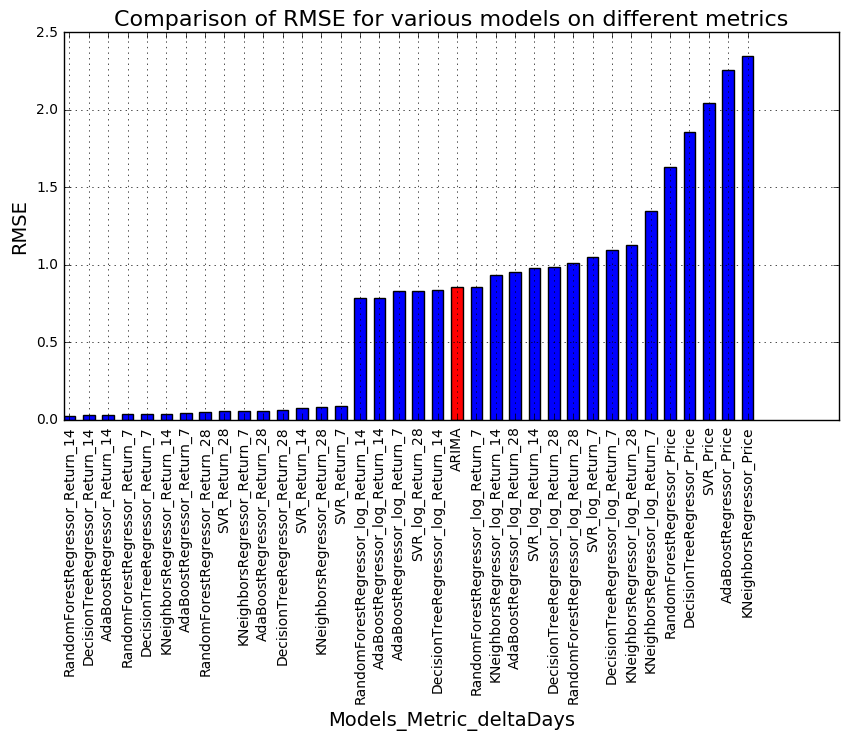

In [38]:
#summary of RMSE for all regressors

all_regressor_RMSE_df=pd.DataFrame(list(all_regressor_RMSE.iteritems()), columns=['key','RMSE'])
all_regressor_RMSE_df=all_regressor_RMSE_df.sort_values(by=['RMSE'],ascending=True)

plt.rcParams['figure.figsize'] = (10.0, 5.0)

colors = []
for model in all_regressor_RMSE_df.key: 
    if model.startswith('ARIMA'):
        colors.append('r')
    else:
        colors.append('b')

#ax=all_regressor_RMSE_df.plot(x=all_regressor_RMSE_df['key'],kind='bar')
ind = np.arange(len(all_regressor_RMSE))
fig = plt.figure()
ax = fig.add_subplot(111)
bar_width = 0.6
ax.bar(ind,all_regressor_RMSE_df['RMSE'], width=bar_width, color=colors) #all_regressor_RMSE_df['key'],

ax.set_ylabel('RMSE',fontsize=14)
ax.set_xlabel('Models_Metric_deltaDays',fontsize=14)
plt.xticks(ind + bar_width / 2, all_regressor_RMSE_df['key'],rotation='vertical')

ax.grid('on')
ax.set_title('Comparison of RMSE for various models on different metrics',fontsize=16)


display(all_regressor_RMSE_df[:10])

***This concludes that RandomForestRegressor, AdaBoostRegressor, SVR on Return of 14days gives the best performance on regression.***

### 2.3. Multiclass classification

The majority of the code is refered from this tutorial:
#http://francescopochetti.com/stock-market-prediction-part-introduction/


In [39]:
#http://francescopochetti.com/stock-market-prediction-part-introduction/
import cPickle
import pystocks

import numpy as np
import pandas as pd
import datetime
from datetime import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import operator
from IPython.display import display
from sklearn.qda import QDA
import re
from dateutil import parser
from backtest import Strategy, Portfolio
import quandl 
import os
import sys


print os.getcwd()

/Users/parksoy/anaconda/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/qda.py:6: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


/Users/parksoy/Desktop/GoogleDrive_Soyoung/Udacity_nanoDegree_MachineLearning/capstone


### 2.3.1. Data preprocessing to include open and close eventually for investment backtesting

In [41]:
#Retrive open, close price
import datetime

lags = [7,14,28]
lag=7
deltas =[7,14,28] 

def add_Features(dataframe, adjclose, returns, delta):
    """
    - delta >= 2, 
    - given Return_* :computes the return of day i with respect to day i-delta. 
    - given AdjClose_* :computes its moving average on delta days
    """
    return_delta = adjclose[9:] + "simpleReturn_" + str(delta)
    dataframe[return_delta] = dataframe[adjclose].pct_change(delta)
    
    roll_delta = returns[7:] + "simpleReturnMA_" + str(delta)
    dataframe[roll_delta] = dataframe[returns].rolling(window=delta,center=False).mean()

def apply_TimeLag(dataset, lags, delta):
    """apply time lag to return columns by delta."""
  
    dataset.Return = dataset.Return.shift(-1)
    maxLag = max(lags)
    columns =[col for col in list(dataset.columns) if col.startswith("Return")] 
    for column in columns:
        for lag in lags:
            newcolumn = column + "_"+str(lag)
            dataset[newcolumn] = dataset[column].shift(lag)
    return dataset.iloc[maxLag:-1,:]

#Execute to prepare dataset

symbol='INTC'
start_test = X_test.index[0]
end_period=X_test.index[-1]

dataset = pd.read_csv('./data/'+ symbol + '.csv', index_col="Date", parse_dates=True)
index_rev=dataset.index.sort_values(ascending=True)
dataset=pd.DataFrame(dataset, index=index_rev)

dataset['Return'] = dataset['Adj Close'].pct_change() 
columns = dataset.columns 
adjclose = columns[-2]
returns = columns[-1]

for delta in deltas:
    add_Features(dataset, adjclose, returns, delta)    

dataset = dataset.interpolate(method='linear')
dataset = dataset.fillna(dataset.mean())

display(dataset[:7])
dataset = apply_TimeLag(dataset, lags, deltas)
display(dataset[:7])
print dataset.shape

,Open,High,Low,Close,Volume,Adj Close,Return,simpleReturn_7,simpleReturnMA_7,simpleReturn_14,simpleReturnMA_14,simpleReturn_28,simpleReturnMA_28
Date,,,,,,,,,,,,,
1997-01-02,131.7500,132.000,127.625000,130.375,97639200,11.206980,0.000528,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506
1997-01-03,133.0000,138.500,132.625000,138.375,95648000,11.894656,0.061361,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506
1997-01-06,139.1250,141.750,137.750000,138.875,120549600,11.937636,0.003613,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506
1997-01-07,138.5625,143.500,137.000000,143.375,96153600,12.324454,0.032403,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506
1997-01-08,144.0000,145.625,141.765594,142.250,125510400,12.227750,-0.007847,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506
1997-01-09,143.3750,144.000,141.750000,143.000,77420000,12.292219,0.005272,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506
1997-01-10,142.1250,144.750,141.500000,144.500,111907200,12.421159,0.010490,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506


,Open,High,Low,Close,Volume,Adj Close,Return,simpleReturn_7,simpleReturnMA_7,simpleReturn_14,simpleReturnMA_14,simpleReturn_28,simpleReturnMA_28,Return_7,Return_14,Return_28
Date,,,,,,,,,,,,,,,,
1997-02-11,154.125,154.750,146.500000,151.750,151842400,13.048687,0.032949,-0.064715,-0.009247,-0.002135,0.000078,0.164336,0.005686,0.010015,-0.002465,0.061361
1997-02-12,151.750,157.000,150.500000,156.750,112742400,13.478627,0.001595,-0.043478,-0.005971,0.033291,0.002607,0.133167,0.004672,0.005339,-0.008237,0.003613
1997-02-13,158.000,159.000,156.000000,157.000,96499200,13.500124,-0.015924,-0.047041,-0.006506,0.043535,0.003309,0.130888,0.004600,-0.045524,-0.002492,0.032403
1997-02-14,156.125,157.000,153.500000,154.500,69313600,13.285154,0.000809,-0.017488,-0.002277,0.029483,0.002350,0.077951,0.002874,-0.026232,0.005829,-0.007847
1997-02-18,154.250,155.125,152.125000,154.625,60033600,13.295903,-0.004850,0.009796,0.001586,0.024346,0.001991,0.087355,0.003183,0.021225,0.025174,0.005272
1997-02-19,154.125,155.750,153.250000,153.875,55190400,13.231412,-0.025995,-0.015987,-0.002139,-0.005654,-0.000153,0.076405,0.002821,-0.030376,0.034733,0.010490
1997-02-20,152.250,153.000,149.359299,149.875,128985600,12.887459,-0.023353,-0.011542,-0.001513,-0.064013,-0.004491,0.037541,0.001518,0.000824,0.013271,0.016436


(5051, 16)


In [42]:
def prepare_DataForClassification(dataset, start_test,lag):
     
    #Feature sets:
    col_list = list(dataset.columns.values)
    features = [item for item in col_list if item.startswith("simple")] #not
    X = dataset[features] 
    
    #Binary classification target
    le = preprocessing.LabelEncoder()
    target_col='Return_'+str(lag)

    dataset['UpDown'] = dataset[target_col]
    dataset.UpDown[dataset.UpDown >= 0] = 'Up'
    dataset.UpDown[dataset.UpDown < 0] = 'Down'
    dataset.UpDown = le.fit(dataset.UpDown).transform(dataset.UpDown)
    y = pd.DataFrame(dataset.UpDown, index=dataset.index)
    display(X.shape)
    display(y.shape)
    
    #Scale all features based on z-score 
    from scipy.stats import zscore

    X_z=X.apply(zscore)

    tscv = TimeSeriesSplit(n_splits=3)

    for train_index, test_index in tscv.split(X):
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, X_test = X_z.iloc[train_index], X_z.iloc[test_index]
    
    return X_train, y_train, X_test, y_test   

X_train, y_train, X_test, y_test=prepare_DataForClassification(dataset, start_test,lag)
print X_train.shape, y_train.shape, X_test.shape, y_test.shape

display(X_train[:3])
display(y_train[:3])

/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(5051, 6)

(5051, 1)

(3789, 6) (3789, 1) (1262, 6) (1262, 1)


,simpleReturn_7,simpleReturnMA_7,simpleReturn_14,simpleReturnMA_14,simpleReturn_28,simpleReturnMA_28
Date,,,,,,
1997-02-11,-1.143145,-1.148881,-0.101552,-0.071497,1.286465,1.236439
1997-02-12,-0.785258,-0.762372,0.331563,0.359888,1.021767,0.994240
1997-02-13,-0.845299,-0.825481,0.456804,0.479656,1.002412,0.977033


,UpDown
Date,
1997-02-11,1
1997-02-12,1
1997-02-13,0


In [53]:
#utils

##############################################################################
# FEATURE AND MODEL SELECTION
maxlags = 14 #10
maxdeltas =3 # 10
folds = 3 #10
grid = {'C': [0.01, 0.1], 'gamma': [0, 1]}
############ SET PARAMETERS ##################################################
parameters = [1, 2, 50, 1] #SVC: C=1, gamma=2, AdaBoost=n_estimators = parameters[3], learning_rate =  parameters[4]
method = 'RF' #'RF''KNN''SVM''ADA''GTB''QDA'
savemodel=False
##############################################################################
#TESTING
import datetime
#cut = datetime.datetime(2011,1,1)

###############################################################################

def count_missing(dataframe):
    return (dataframe.shape[0] * dataframe.shape[1]) - dataframe.count().sum()

def perform_CV(X_train, y_train, folds, method, parameters, savemodel):
    print '\n    **************Start of PERFORM CV***********\n'
    print '      Parameters -----> ', parameters
    print '      trainset.shape: ', X_train.shape

    k = int(np.floor(float(X_train.shape[0])/folds))

    print '      Each fold.size: ', k

    acc = np.zeros(folds-1)
    for i in range(2, folds+1):
        
        split = float(i-1)/i
        print '      Splitting ' + str(i) + 'chuncks at ' + str(i-1) + '/' + str(i)
        data = X_train[:(k*i)]
        output = y_train[:(k*i)]
        print '      Train+test.shape: ', data.shape
        index = int(np.floor(data.shape[0]*split))
        X_tr = data[:index]
        y_tr = output[:index]

        X_te = data[(index+1):]
        y_te = output[(index+1):]

        acc[i-2] = perform_Classification(X_tr, y_tr, X_te, y_te, method, parameters,savemodel)
        print '      Accuracy on fold ' + str(i) + ': ', acc[i-2]
    print '\n        **************End of PERFORM CV********\n'
    return acc.mean()


def perform_TimeSeriesSearchGrid(X_train, y_train, folds, method, grid, savemodel):
    """
    parameters is a dictionary with: keys --> parameter , values --> list of values of parameter
    """
    print ''
    print '          **************************Performing Search Grid CV...'
    print '          Algorithm: ', method
    param = grid.keys()
    finalGrid = {}
    if len(param) == 1:
        for value_0 in grid[param[0]]:
            parameters = [value_0]
            accuracy = perform_CV(X_train, y_train, folds, method, parameters, savemodel)
            finalGrid[accuracy] = parameters
        final = sorted(finalGrid.iteritems(), key=operator.itemgetter(0), reverse=True)
        print finalGrid
        print '          Final CV Results: ', final
        return final[0]

    elif len(param) == 2:
        for value_0 in grid[param[0]]:
            for value_1 in grid[param[1]]:
                parameters = [value_0, value_1]
                accuracy = perform_CV(X_train, y_train, folds, method, parameters, savemodel)
                finalGrid[accuracy] = parameters
        final = sorted(finalGrid.iteritems(), key=operator.itemgetter(0), reverse=True)
        print finalGrid
        print '          Final CV Results: ', final
        return final[0]

methods=[RandomForestClassifier(n_estimators=1000, n_jobs=-1),
         neighbors.KNeighborsClassifier(),
         SVC(C=parameters[0],gamma=parameters[1]), # C=1, gamma=2,
         AdaBoostClassifier(n_estimators=parameters[2],learning_rate=parameters[3]), #n = parameters[0],l =  parameters[1]
         GradientBoostingClassifier(n_estimators=100)
        ]

method=RandomForestClassifier(n_estimators=1000, n_jobs=-1)

def perform_Classification(X_train, y_train, X_test, y_test, method, parameters, savemodel):

    clf = method
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    
    if clf==RandomForestClassifier(n_estimators=1000, n_jobs=-1):
        importance=clf.feature_importances_
        indices = np.argsort(importance)[::-1]
        for f in range(X_train.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importance[indices[f]]))
    if savemodel == True:
        fname_out = '{}-{}.pickle'.format(symbol, datetime.now())
        with open(fname_out, 'wb') as f:
            cPickle.dump(clf, f, -1)    
    
    y_pred=clf.predict(X_test)
    acc_score=clf.score(X_test, y_test)
    f1_score=metrics.f1_score(y_test, y_pred)  
    
    return acc_score,f1_score


# Select the best model, parameters
### Set the range of parameters to experiment

In [44]:
#from datetime import datetime

def perform_FeatureSelection(maxdeltas, maxlags,start_test, dataset, savemodel, method, folds, parameters):
    display(dataset[:2])
    for lag in lags:
        print '=========lag=',lag,'========='
        for delta in deltas:
            print '    *****************Delta days',delta,'******************'
            X_train, y_train, X_test, y_test  = prepare_DataForClassification(dataset, start_test,lag)
            accuracy=perform_CV(X_train, y_train, folds, method, parameters, savemodel)
            print "Accuracy of CV=", accuracy

perform_FeatureSelection(maxdeltas, maxlags, start_test, dataset, savemodel, method, folds, parameters)

print "Feature Selection Done!"

,Open,High,Low,Close,Volume,Adj Close,Return,simpleReturn_7,simpleReturnMA_7,simpleReturn_14,simpleReturnMA_14,simpleReturn_28,simpleReturnMA_28,Return_7,Return_14,Return_28,UpDown
Date,,,,,,,,,,,,,,,,,
1997-02-11,154.125,154.75,146.5,151.75,151842400,13.048687,0.032949,-0.064715,-0.009247,-0.002135,0.000078,0.164336,0.005686,0.010015,-0.002465,0.061361,1
1997-02-12,151.750,157.00,150.5,156.75,112742400,13.478627,0.001595,-0.043478,-0.005971,0.033291,0.002607,0.133167,0.004672,0.005339,-0.008237,0.003613,1


=========lag= 7 =========
    *****************Delta days 7 ******************


/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(5051, 6)

(5051, 1)

/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



    **************Start of PERFORM CV***********

      Parameters ----->  [1, 2, 50, 1]
      trainset.shape:  (3789, 6)
      Each fold.size:  1263

      Splitting the first 2chuncks at 1/2
      Train+test.shape:  (2526, 6)
      Accuracy on fold 2:  0.548335974643

      Splitting the first 3chuncks at 2/3
      Train+test.shape:  (3789, 6)
      Accuracy on fold 3:  0.572107765452

        **************End of PERFORM CV********

Accuracy of CV= 0.560221870048
    *****************Delta days 14 ******************


(5051, 6)

(5051, 1)


    **************Start of PERFORM CV***********

      Parameters ----->  [1, 2, 50, 1]
      trainset.shape:  (3789, 6)
      Each fold.size:  1263

      Splitting the first 2chuncks at 1/2
      Train+test.shape:  (2526, 6)
      Accuracy on fold 2:  0.539619651347

      Splitting the first 3chuncks at 2/3
      Train+test.shape:  (3789, 6)
      Accuracy on fold 3:  0.572900158479

        **************End of PERFORM CV********

Accuracy of CV= 0.556259904913
    *****************Delta days 28 ******************


(5051, 6)

(5051, 1)


    **************Start of PERFORM CV***********

      Parameters ----->  [1, 2, 50, 1]
      trainset.shape:  (3789, 6)
      Each fold.size:  1263

      Splitting the first 2chuncks at 1/2
      Train+test.shape:  (2526, 6)
      Accuracy on fold 2:  0.543581616482

      Splitting the first 3chuncks at 2/3
      Train+test.shape:  (3789, 6)
      Accuracy on fold 3:  0.571315372425

        **************End of PERFORM CV********

Accuracy of CV= 0.557448494453
=========lag= 14 =========
    *****************Delta days 7 ******************


(5051, 6)

(5051, 1)


    **************Start of PERFORM CV***********

      Parameters ----->  [1, 2, 50, 1]
      trainset.shape:  (3789, 6)
      Each fold.size:  1263

      Splitting the first 2chuncks at 1/2
      Train+test.shape:  (2526, 6)
      Accuracy on fold 2:  0.56735340729

      Splitting the first 3chuncks at 2/3
      Train+test.shape:  (3789, 6)
      Accuracy on fold 3:  0.571315372425

        **************End of PERFORM CV********

Accuracy of CV= 0.569334389857
    *****************Delta days 14 ******************


(5051, 6)

(5051, 1)


    **************Start of PERFORM CV***********

      Parameters ----->  [1, 2, 50, 1]
      trainset.shape:  (3789, 6)
      Each fold.size:  1263

      Splitting the first 2chuncks at 1/2
      Train+test.shape:  (2526, 6)
      Accuracy on fold 2:  0.571315372425

      Splitting the first 3chuncks at 2/3
      Train+test.shape:  (3789, 6)
      Accuracy on fold 3:  0.568938193344

        **************End of PERFORM CV********

Accuracy of CV= 0.570126782884
    *****************Delta days 28 ******************


(5051, 6)

(5051, 1)


    **************Start of PERFORM CV***********

      Parameters ----->  [1, 2, 50, 1]
      trainset.shape:  (3789, 6)
      Each fold.size:  1263

      Splitting the first 2chuncks at 1/2
      Train+test.shape:  (2526, 6)
      Accuracy on fold 2:  0.56735340729

      Splitting the first 3chuncks at 2/3
      Train+test.shape:  (3789, 6)
      Accuracy on fold 3:  0.566561014263

        **************End of PERFORM CV********

Accuracy of CV= 0.566957210777
=========lag= 28 =========
    *****************Delta days 7 ******************


(5051, 6)

(5051, 1)


    **************Start of PERFORM CV***********

      Parameters ----->  [1, 2, 50, 1]
      trainset.shape:  (3789, 6)
      Each fold.size:  1263

      Splitting the first 2chuncks at 1/2
      Train+test.shape:  (2526, 6)
      Accuracy on fold 2:  0.52852614897

      Splitting the first 3chuncks at 2/3
      Train+test.shape:  (3789, 6)
      Accuracy on fold 3:  0.525356576862

        **************End of PERFORM CV********

Accuracy of CV= 0.526941362916
    *****************Delta days 14 ******************


(5051, 6)

(5051, 1)


    **************Start of PERFORM CV***********

      Parameters ----->  [1, 2, 50, 1]
      trainset.shape:  (3789, 6)
      Each fold.size:  1263

      Splitting the first 2chuncks at 1/2
      Train+test.shape:  (2526, 6)
      Accuracy on fold 2:  0.523771790808

      Splitting the first 3chuncks at 2/3
      Train+test.shape:  (3789, 6)
      Accuracy on fold 3:  0.526148969889

        **************End of PERFORM CV********

Accuracy of CV= 0.524960380349
    *****************Delta days 28 ******************


(5051, 6)

(5051, 1)


    **************Start of PERFORM CV***********

      Parameters ----->  [1, 2, 50, 1]
      trainset.shape:  (3789, 6)
      Each fold.size:  1263

      Splitting the first 2chuncks at 1/2
      Train+test.shape:  (2526, 6)
      Accuracy on fold 2:  0.526941362916

      Splitting the first 3chuncks at 2/3
      Train+test.shape:  (3789, 6)
      Accuracy on fold 3:  0.512678288431

        **************End of PERFORM CV********

Accuracy of CV= 0.519809825674
Feature Selection Done!


# AFTER BEST MODEL SELECTION-predict!!
### Run model for the entire trainset and save the model in pickle. Understand feature importance at the end

In [45]:
################################################################################
# AFTER BEST MODEL SELECTION
bestlags = 7#9
bestdelta = 5#9
savemodel = True
##############################################################################
parameters=[]

from datetime import datetime

def perform_SingleShotClassification(bestdelta, bestlags, start_test, dataset, savemodel, method, parameters):
    print 'lag:', max(lags)
    delta = range(2, bestdelta + 1)
    print 'Delta: ', max(delta)
    X_train, y_train, X_test, y_test  = prepare_DataForClassification(dataset, start_test,lag)
    return perform_Classification(X_train, y_train, X_test, y_test, method, parameters, savemodel)

###############################################################################
accuracy=perform_SingleShotClassification(bestdelta, bestlags, start_test, dataset, savemodel, method, parameters)

print "\nAccuracy of the entire trainset=", accuracy

lag: 28
Delta:  5


/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(5051, 6)

(5051, 1)

/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Accuracy of the entire trainset= 0.56735340729


In [46]:
import glob

list_pickle=glob.glob("./*.pickle")
bestModel_pickles=[pickle for pickle in list_pickle if pickle.find(symbol)!=-1]
bestModel_pickle=sorted(bestModel_pickles)[-1]
print bestModel_pickle

./INTC-2017-03-23 08:49:53.675404.pickle


# Prediction From BestModel.pickle

In [58]:
#PREDICTION
from sklearn import metrics

# calls the best model previously saved in pickle file and runs it on the test set 
# retutning an array of 0,1 (Down, Up) according to predicted returns
best_model = bestModel_pickle

def getPrediction_FromBestModel(bestdelta, bestlags, fout, start_test, dataset, best_model):
    """returns array of prediction and score from best model."""
    
    lags = range(2, bestlags + 1) 
    delta = range(2, bestdelta + 1) 
    X_train, y_train, X_test, y_test  = prepare_DataForClassification(dataset, start_test,lag)    
    
    with open(best_model, 'rb') as fin:
        model = cPickle.load(fin)        
    
    y_pred=model.predict(X_test)
    acc_score=model.score(X_test, y_test)
    f1_score=metrics.f1_score(y_test, y_pred)  

    return f1_score

f1_score= getPrediction_FromBestModel(bestdelta, bestlags, symbol, start_test, dataset, best_model=best_model)#[0]

print "f1_score of best model=",f1_score

/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(5051, 6)

(5051, 1)

f1_score of best model= 0.599706744868


In [48]:
print dataset.shape, X_test.shape, prediction.shape
print X_test.index[0], X_test.index[-1]

display(X_test[:2])
display(X_test[-2:])
X_test=X_test.sort_index(ascending=True)
display(X_test[:2])
display(X_test[-2:])

(5051, 17) (1262, 6) (1262,)
2012-03-02 00:00:00 2017-03-08 00:00:00


,simpleReturn_7,simpleReturnMA_7,simpleReturn_14,simpleReturnMA_14,simpleReturn_28,simpleReturnMA_28
Date,,,,,,
2012-03-02,0.067240,0.064827,0.025284,0.023004,0.026035,0.022066
2012-03-05,-0.128402,-0.128939,-0.148718,-0.148944,-0.155827,-0.158900


,simpleReturn_7,simpleReturnMA_7,simpleReturn_14,simpleReturnMA_14,simpleReturn_28,simpleReturnMA_28
Date,,,,,,
2017-03-07,-0.389318,-0.396044,-0.119690,-0.125055,-0.501039,-0.513935
2017-03-08,-0.463355,-0.471554,-0.221284,-0.226984,-0.490269,-0.502673


,simpleReturn_7,simpleReturnMA_7,simpleReturn_14,simpleReturnMA_14,simpleReturn_28,simpleReturnMA_28
Date,,,,,,
2012-03-02,0.067240,0.064827,0.025284,0.023004,0.026035,0.022066
2012-03-05,-0.128402,-0.128939,-0.148718,-0.148944,-0.155827,-0.158900


,simpleReturn_7,simpleReturnMA_7,simpleReturn_14,simpleReturnMA_14,simpleReturn_28,simpleReturnMA_28
Date,,,,,,
2017-03-07,-0.389318,-0.396044,-0.119690,-0.125055,-0.501039,-0.513935
2017-03-08,-0.463355,-0.471554,-0.221284,-0.226984,-0.490269,-0.502673


# NOW TRADE!!!

In [49]:
# dataframe of S&P 500 historical prices (saved locally from Yahho Finance)
bars = pd.read_csv('./data/'+symbol+'.csv', index_col='Date', parse_dates=True) 
display(bars[:2])
display(bars[-2:])

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2017-03-09,35.599998,35.939999,35.500000,35.820000,23543100,35.820000
2017-03-08,35.669998,35.900002,35.529999,35.619999,20899400,35.619999


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1997-01-03,133.00,138.5,132.625,138.375,95648000,11.894656
1997-01-02,131.75,132.0,127.625,130.375,97639200,11.206980


In [50]:
class MarketIntradayPortfolio(Portfolio):
    """Buys or sells 500 shares of an asset at the opening price of
    every bar, depending upon the direction of the forecast, closing 
    out the trade at the close of the bar.

    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    bars - A DataFrame of bars for a symbol set.
    signals - A pandas DataFrame of signals (1, -1) for each symbol.
    initial_capital - The amount in cash at the start of the portfolio."""

    def __init__(self, symbol, bars, signals, initial_capital=100000.0, shares=500):
        self.symbol = symbol        
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.shares = int(shares)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        """Generate the positions DataFrame, based on the signals
        provided by the 'signals' DataFrame."""
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)

        positions[self.symbol] = self.shares*self.signals['signal']
        return positions
                    
    def backtest_portfolio(self):
        """Backtest the portfolio and return a DataFrame containing
        the equity curve and the percentage returns."""
       
        portfolio = pd.DataFrame(index=self.positions.index)
        pos_diff = self.positions.diff()
            
        portfolio['price_diff'] = self.bars['Close']-self.bars['Open']
        portfolio['price_diff'][0:5] = 0.0
        portfolio['profit'] = self.positions[self.symbol] * portfolio['price_diff']
     
        portfolio['total'] = self.initial_capital + portfolio['profit'].cumsum()
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

In [51]:
# last trading day accounted
import datetime

start_test = X_test.index[-1]  #2014-04-01 00:00:00
end_period = X_test.index[0]  #2017-02-16 00:00:00 

# subset of the data corresponding to test set
start_test=start_test.strftime("%Y%m%d") ##2014-04-01 00:00:00
end_period=end_period.strftime("%Y%m%d") #2017-02-16 00:00:00 

bars = bars.loc[X_test.index] #start_test:end_period 2017-02-16 00:00:00 2014-04-02 00:00:00
print bars.index[0],bars.index[-1]

# initialize empty dataframe indexed as the bars. 
#There's going to be perfect match between dates in bars and signals 
signals = pd.DataFrame(index=bars.index) ##2017-02-16 00:00:00 2014-04-02 00:00:00
print signals.shape #726

# initialize signals.signal column to zero
signals['signal'] = 0.0

# copying into signals.signal column results of prediction
signals['signal'] = prediction
print prediction.shape

# replace the zeros with -1 (new encoding for Down day)
signals.signal[signals.signal == 0] = -1

# compute the difference between consecutive entries in signals.signal. As
# signals.signal was an array of 1 and -1 return signals.positions will 
# be an array of 0s and 2s.
signals['positions'] = signals['signal'].diff()

# calling portfolio evaluation on signals (predicted returns) and bars 
# (actual returns)
portfolio = MarketIntradayPortfolio(symbol, bars, signals)

# backtesting the portfolio and generating returns on top of that 
returns = portfolio.backtest_portfolio()

display(signals[:3])
display(returns[:3])


2012-03-02 00:00:00 2017-03-08 00:00:00
(1262, 0)
(1262,)


,signal,positions
Date,,
2012-03-02,-1,NaN
2012-03-05,1,2.0
2012-03-06,1,0.0


,price_diff,profit,total,returns
Date,,,,
2012-03-02,0.0,-0.0,100000.0,NaN
2012-03-05,0.0,0.0,100000.0,0.0
2012-03-06,0.0,0.0,100000.0,0.0


# Plotting backtesting

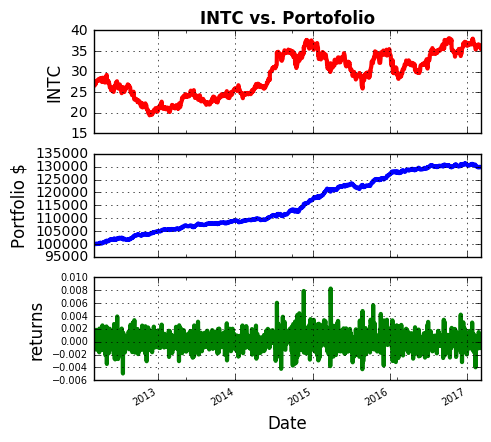

In [52]:
import matplotlib.pyplot as plt
import pylab as pl

plt.rcParams['figure.figsize'] = (5.0, 5.0)
# Plot results
f, ax = plt.subplots(3, sharex=True)

bars['Close'].plot(ax=ax[0], color='r', lw=3.)    
ax[0].set_ylabel(symbol, fontsize=12)
ax[0].set_xlabel('', fontsize=12)
#ax[0].legend(('S&P-500',), loc='upper left', prop={"size":12})
ax[0].set_title(symbol+' vs. Portofolio', fontsize=12, fontweight="bold")
ax[0].grid(True)

returns['total'].plot(ax=ax[1], color='b', lw=3.)  
ax[1].set_ylabel('Portfolio $', fontsize=12)
ax[1].set_xlabel('Date', fontsize=12)
#ax[1].legend(('Portofolio',), loc='upper left', prop={"size":12})            
ax[1].grid(True)

returns['returns'].plot(ax=ax[2], color='g', lw=3.)  
ax[2].set_ylabel('returns', fontsize=12)
ax[2].set_xlabel('Date', fontsize=12)
#ax[2].legend(('Portofolio',), loc='upper left', prop={"size":12})            
ax[2].grid(True)

plt.tick_params(axis='both', which='major', labelsize=7)
plt.show()